<a href="https://colab.research.google.com/github/K-Chorna02/DST_Assessment_2/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction



We focus on Image classification using Convolutional Neural Networks, a widely applicable and impactful use of CNNs with many real-world applications. Image classification is very important in a range of fields including tagging images in social media posts, in search engines such as Google, dietary tracking apps or medical settings.

Our goal is to investigate how different optimisation strategies and model architectures affect classification accuracy and robustness, and to determine which methods generalise best when scaled to more complex and realistic datasets.

Throughout our project we each carried out a related task to learn more about Neural Networks.
We began exploring CIFAR-10, which we treated as a toy dataset due to its low resolution and small number of classes to learn more about optimisation and how the changing of hyperparameters (such as batch size, learning rate and optimizer) affects the performance of models.

We then generalised to a more realistic dataset,(Food 101) where we created commonly seen CNN models from scratch (ResNet18 and ViT models) alongside using transfer learning.
Our choice in models was justified by a literature review and by our limited resources and time constraints, which we discuss in more detail in the ResNet18 and ViT sections of this report.

Food101 was the most appropriate dataset to explore after testing on CIFAR-10 as it was the perfect balance between real-world complexity while also being feasible to work with. We downsampled to a resolution of 64x64 for training purposes.  

Food image classification is increasingly relevant with the growing popularity of dieting apps to track calories and nutrients, which require successful identification of the food in question. The Food101 dataset mirrors this real-world application as the dataset consists of real photos of food uploaded by people across the world.

Finally, we tested their robustness by changing our test sets to make them harder for the model to interpret, e.g. adding Gaussian blur or changing the brightness of our images. This allowed us to examine whether certain architectures were more resilient to visual noise than others, mimicking scenarios that may be seen in a real-world setting.




# Limitations
We faced a few limitations within our project:
- Colab GPU limitations
- Time constraint
- Memory
- Knowledge of Neural Networks

Due to the fact we would be training models over thousands of pieces of data across many epochs, GPUs would be required, so we chose to use Collab for our coding. However, this still only provided us with limited access.

We only had 3 weeks to complete this project, so we had to ensure we had enough time to train our models and evaluate their performance, so we chose our models accordingly so that they would be achievable.

We chose our goal with these in mind.


# Libraries

In [1]:
#Loading necessary libraries
import torch #creates/trains models and performs tensor operations
import torchvision #gives popular datasets, model architectures and image processing stuff
import torchvision.transforms as transforms #helps preprocess images to help model use them
import matplotlib.pyplot as plt #for plotting
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import Subset

#libraries used for EDA
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import entropy

#libraries used for Robustness
import cv2
import torchvision.transforms.functional as TF

#resnnet18
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from torchvision import models, datasets, transforms

#ViT

#t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



# About our datasets

## CIFAR-10

The CIFAR-10 dataset can be found online at: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

This is a widely used benchmark dataset created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, used for image classification in machine learning methods.

It consists of 60,000 sets of 32x32 images split into 10 classes, such as planes, cars, birds, cats, etc. Of these 50,000 are used for training and the remaining 10,000 are used for testing.
This makes it a perfect starting point for our project, serving as a toy dataset to better understand neural networks. Due to its low resolution, we are able to explore the impacts of different hyperparameters and hence optimise our neural network.

By experimenting and exploring the effects of different optimisation approaches on CIFAR-10, we aim to understand which approaches generalise well before applying them to larger and more complex datasets.
We note some may improve performance specifically on this data set but not generalise so well.

Below we load CIFAR-10:




In [2]:
batch_size = 10 #we can vary the batch size, but this basically shows that ...

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) # discuss transforms

In [3]:
#downloading
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#info
print(f"Training samples: {len(trainset)}")
print(f"Testing samples: {len(testset)}")
print(f"Classes: {trainset.classes}")


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Training samples: 50000
Testing samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Now we've loaded the data and we can see the names of the 10 classes and the number of test vs training samples, we can now visualise a small sample (10 images) of the data:

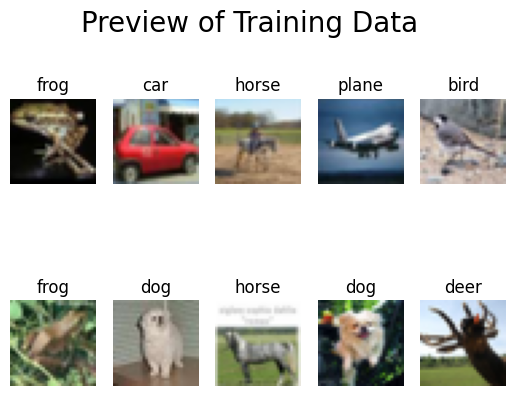

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(trainloader)
images, labels = next(dataiter) #slight modification here to account for python update

for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions (SEE CELL BELOW)
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

We check to see how many images for each class:

In [ ]:
from collections import Counter
labels = [label for _, label in trainset]
label_counts = Counter(labels)

for idx, count in label_counts.items():
    print(f"{trainset.classes[idx]}: {count}")

print(images.shape)

frog: 5000
truck: 5000
deer: 5000
automobile: 5000
bird: 5000
horse: 5000
ship: 5000
cat: 5000
dog: 5000
airplane: 5000
torch.Size([10, 3, 32, 32])


Since this dataset has been collected in an artificial environment and transformed, we know that there is an even class distribution with all images having the same 32x32 pixel dimensions.

Since we are exploring how different model architectures perform against one another, the CIFAR-10 is reasonably small whilst still containing images that are somewhat complex, making it appropriate for our initial explorations before we scale to larger datasets. The 32x32 dimensions of the CIFAR-10 dataset means it is quicker to run when we are limited by GPU resources.

###EDA on CIFAR-10
Exploratory data analysis allows us to gain more information about our dataset. We find the mean and standard deviations of our colour channels, explore how these vary for each class, and consider the entropy of our dataset.

#### Mean and std of channels
We can obtain information about the mean and standard deviation of the colour channels:

In [ ]:
import torch
all_pixels = torch.cat([images.view(-1, 3) for images, _ in trainloader], dim=0)

print(all_pixels.mean(dim=0))#mean
print(all_pixels.std(dim=0))#std
#this gives us the mean and std for each channel of RGB.

class_means = {}
class_stds = {}

for cls in range(10):
    pixels = []
    for images, labels in trainloader:
        cls_images = images[labels == cls]#selecting only images of this class
        if len(cls_images) == 0:
            continue
        pixels.append(cls_images.view(-1, 3))

    pixels = torch.cat(pixels, dim=0)
    class_means[cls] = pixels.mean(dim=0)
    class_stds[cls] = pixels.std(dim=0)

print(class_means)
print(class_stds)


tensor([-0.0533, -0.0533, -0.0533])
tensor([0.5031, 0.5031, 0.5032])
{0: tensor([0.1165, 0.1166, 0.1167]), 1: tensor([-0.0847, -0.0847, -0.0847]), 2: tensor([-0.0635, -0.0634, -0.0636]), 3: tensor([-0.0883, -0.0884, -0.0884]), 4: tensor([-0.1233, -0.1233, -0.1234]), 5: tensor([-0.0792, -0.0792, -0.0793]), 6: tensor([-0.1642, -0.1642, -0.1643]), 7: tensor([-0.0675, -0.0675, -0.0676]), 8: tensor([0.0468, 0.0469, 0.0470]), 9: tensor([-0.0253, -0.0253, -0.0252])}
{0: tensor([0.5078, 0.5077, 0.5078]), 1: tensor([0.5396, 0.5396, 0.5397]), 2: tensor([0.4655, 0.4655, 0.4656]), 3: tensor([0.5156, 0.5156, 0.5156]), 4: tensor([0.4324, 0.4323, 0.4323]), 5: tensor([0.5001, 0.5001, 0.5002]), 6: tensor([0.4578, 0.4578, 0.4578]), 7: tensor([0.4978, 0.4978, 0.4978]), 8: tensor([0.4975, 0.4974, 0.4974]), 9: tensor([0.5458, 0.5458, 0.5459])}


As we can see, the mean and std for each of the RGB colour channels are very even. We looked at the RGB distribution for each class to see if one had a larger presence of one colour than the other, which may affect the way the model learns to predict certain colours, but we see these are very similar, making this a very useful dataset.

#### Statistical pixel analysis

We can also carry out a statistical pixel analysis for each channel of our dataset:

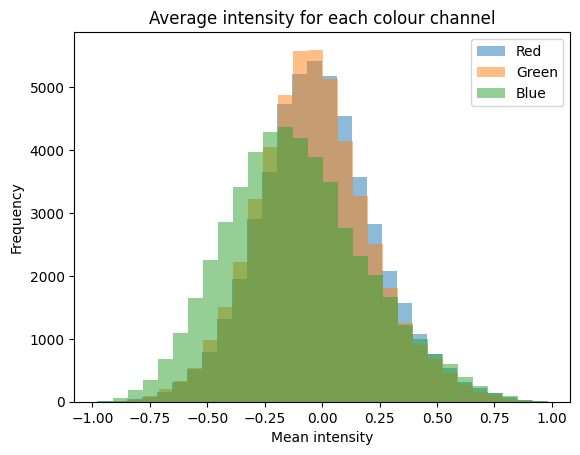

In [ ]:
r_means, g_means, b_means = [], [], []#red, green, blue
for images, _ in trainloader: #we loop through the dataset in batches
    r_channel = images[:, 0, :, :]
    g_channel = images[:, 1, :, :]
    b_channel = images[:, 2, :, :]

    r_np = r_channel.numpy()
    g_np = g_channel.numpy()
    b_np = b_channel.numpy()
#then comoute means after numpy
    for i in range(r_np.shape[0]):
        r_means.append(np.mean(r_np[i]))
        g_means.append(np.mean(g_np[i]))
        b_means.append(np.mean(b_np[i]))

plt.hist(r_means, bins=30, alpha=0.5, label='Red')
plt.hist(g_means, bins=30, alpha=0.5, label='Green')
plt.hist(b_means, bins=30, alpha=0.5, label='Blue')
plt.legend()
plt.title("Average intensity for each colour channel")
plt.xlabel("Mean intensity")
plt.ylabel("Frequency")
plt.show()


The above plot shows that each of the colours are centred around 0, suggesting similar colour distributions across all images. This shows our dataset is well balanced and diverse in terms of colours.


#### PCA
We can apply Principal Component Analysis, a dimensionality reduction method that projects high-dimensional image data onto a lower-dimensional space while preserving as much variance as possible. This allows us to visualise key variance patterns across our dataset.

Since our CIFAR-10 data is composed of 32x32 pixels, so each image becomes a 3072-dimensional feature vector once flattened. Using PCA, we can visualise this in 2D while capturing dominant patterns of variation across images.

However, PCA treats all pixels as independent features and ignores the spatial structure, meaning we can't use this to fully capture the true representational complexity of image data. However, it is a useful tool to get an overview variation across the dataset.

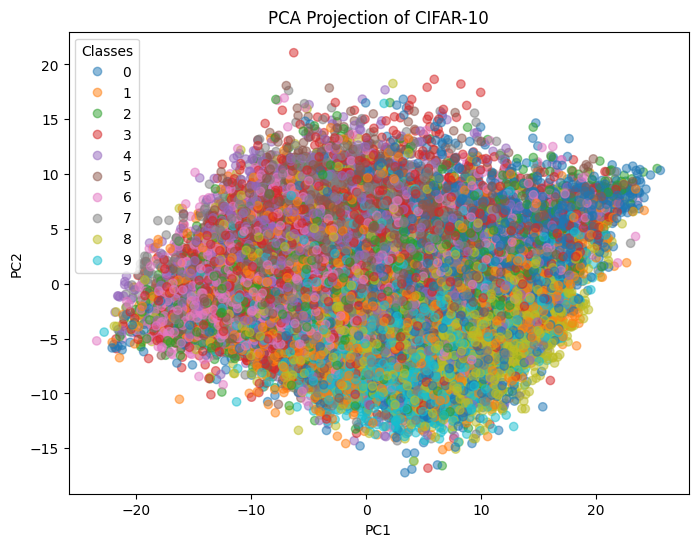

In [ ]:
#loading dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000, shuffle=False)

#we take one big batch of all training data
images, labels = next(iter(trainloader))

#then flatten images and shape
X = images.view(images.shape[0], -1).numpy()
labels = labels.numpy()
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

#now we plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA Projection of CIFAR-10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



The plot of PCA shows us that some variation was captured by the principal components, since there is some loose structure in the points when projected along the two principal component axis.

However, the classes were not clearly separable in 2D PCA space. This is to be expected from PCA and aligns with existing literature, as it struggles to clearly distinguish classes.

#### Entropy

Entropy is essentially a metric for the average amount of information contained in the image.
We use it to measure how unpredictable or random a distribution is [4].
So in the context of our image classification, this is a measure of how varied the pixel intensities are. The final entropy value is the average entropy across all three RGB channels.

We use Shannon entropy, defined as follows:

$H(X)=-\sum^n_{i=1} p_i log(p_i)$

Where $p_i$ represents the probability of the i-th pixel intensity value. For our dataset, we treat each colour channel (RGB) as a separate probability distribution. We estimate this distribution by computing a histogram of pixel intensities, normalise it to obtain probabilities, and then compute entropy for each channel.

Images with high entropy are hard to compress since they contain lots of detail, those with low entropy have smoother regions.

In [ ]:
def image_entropy(img):
    img = img.squeeze()
    entropies = []

    for c in range(3):
        channel = img[c].flatten()
        hist = torch.histc(channel, bins=256, min=0.0, max=1.0)
        if hist.sum() == 0:
            continue
        hist = hist / hist.sum()
        entropies.append(entropy(hist.cpu().numpy() + 1e-8))

    if len(entropies) == 0:
        return 0
    return sum(entropies) / len(entropies)
entropies = []
for img, _ in trainloader:
    entropies.append(image_entropy(img[0]))
avg_entropy = sum(entropies) / len(entropies)
print(f"Average entropy for CIFAR-10: {avg_entropy:.4f}")



Average entropy for CIFAR-10: 4.8230


Here we saw that the average entropy was between 4 and 5 (nats), which shows a moderately high level of variability. In real-world settings, we expect our data to have a higher entropy as datasets contain a wide range of colours, textures, and shapes.


## Food 101

The CIFAR-10 is an idealised dataset where images are transformed to make them better suited to image classification. However, this is not reflective of real-world scenarios so we decided to focus on a more complex dataset.

We explored various datasets including TinyImageNet and CIFAR-100, however these datasets were highly complex and hard to distinguish when downsampled for our training purposes. These would have required a larger amount of preprocessing, shifting the focus of the project away from architectural exploration and towards data cleaning.

The Food 101 dataset is a large scale dataset composed of realistic photos taken of different dishes. The data set was compiled by [1] who used images from 'foodspotting.com', a site that allows users to take images of what they are eating, annotate place and type of food, and upload the information online, resulting in this open source dataset.
The creators [1] created this with the aim of using image clasification with different dishes.

Food typically does not exhibit any distinctive spatial layout, unlike images in the CIFAR-10 dataset where an image with a plane often follows expected visual compositions of the sky in the background.
The images themselves are taken from different angles, different lightings, viewpoints and background context.
For this reason we felt this dataset reflected the complexities of real life scenarios.

This dataset consists of 101 food categories, with 101, 000 images. For each class, 250 manually cleaned test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

This dataset demonstrates a more realistic progression beyond CIFAR-10, allowing us to investigate deeper architectural choices, such as ResNet-18 and ViTs, before comparing model performance under imperfect, real-world conditions.

The data is split in the following way:
- Train: 75,750
- Test: 25,250

Below we import the dataset to get an overview :



In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#loading Food-101 dataset
food_root = "data"
train_dataset = datasets.Food101(root=food_root, split="train", download=True)
test_dataset  = datasets.Food101(root=food_root, split="test",  download=True)

print(f"Full train size: {len(train_dataset)}, test size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

100%|██████████| 5.00G/5.00G [03:59<00:00, 20.8MB/s]


Full train size: 75750, test size: 25250
Number of classes: 101


Note: The original resolution is 256x256 but due to our limited GPU resources, we downsampled to 64x64 to train our models effectively.

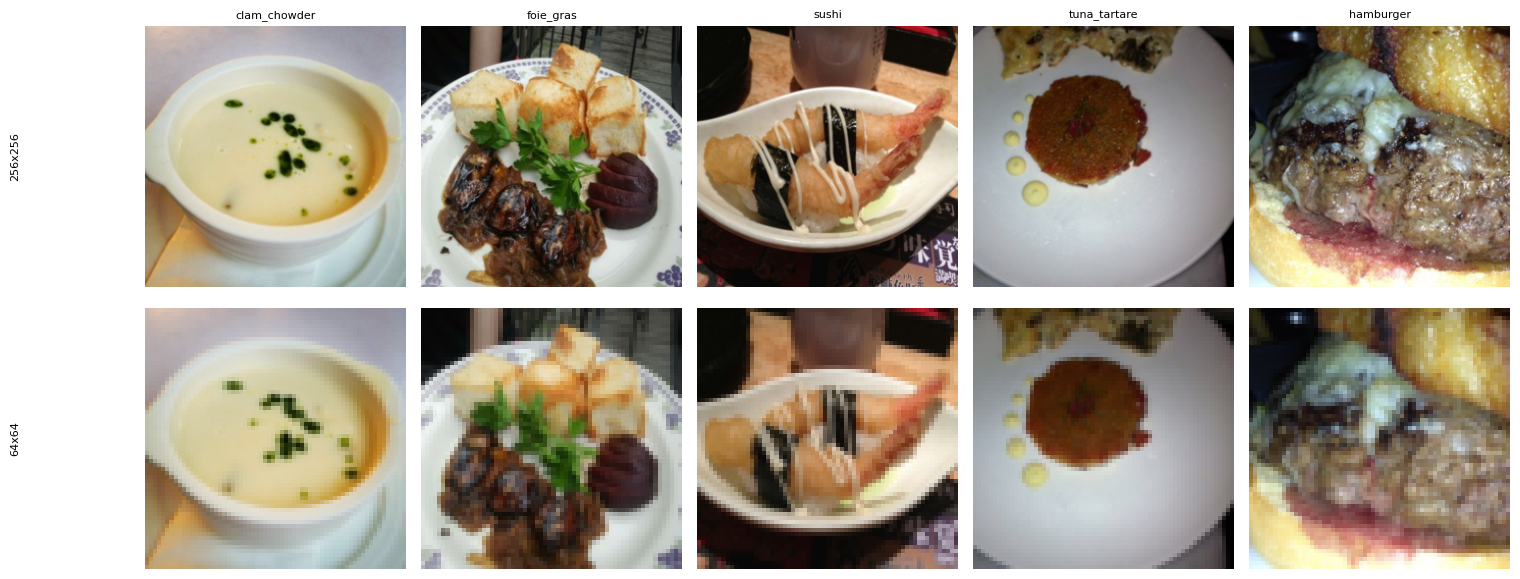

In [37]:
subset_train_idx = random.sample(range(len(train_dataset)), 5)  # pick 5 random images
train_subset = Subset(train_dataset, subset_train_idx)

#we transform to 64x64 from the original 256
resolutions = [256, 64]
transforms_dict = {r: transforms.Compose([transforms.Resize((r,r)), transforms.ToTensor()]) for r in resolutions}
def plot_same_images_with_labels(dataset, resolutions):
    n = len(dataset)  #number of images in subset
    fig, axs = plt.subplots(len(resolutions), n, figsize=(n*3, len(resolutions)*3))

    for j in range(n):
        img, label_idx = dataset[j]
        label = dataset.dataset.classes[label_idx]#to get the class name
        for i, r in enumerate(resolutions):
            img_r = transforms_dict[r](img) #resizing
            img_np = img_r.permute(1,2,0).numpy()
            axs[i,j].imshow(img_np)
            axs[i,j].axis('off')

            if i == 0:
                axs[i,j].set_title(f"{label}", fontsize=8)
            if j == 0:
                axs[i,j].text(-0.5, 0.5, f"{r}x{r}", rotation=90, fontsize=8, va='center', ha='center', transform=axs[i,j].transAxes)
    plt.tight_layout()
    plt.show()

plot_same_images_with_labels(train_subset, resolutions)


In [38]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
#preparing our test and train
#making 64x64
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


train_dataset64 = datasets.Food101(root="data", split="train", download=False, transform=transform)
test_dataset64  = datasets.Food101(root="data", split="test",  download=False, transform=transform)

train_loader64 = DataLoader(train_dataset64, batch_size=64, shuffle=True)
test_loader64  = DataLoader(test_dataset64, batch_size=64, shuffle=False)

We can see that reducing the resolution in this way makes the images much harder to identify, but due to limitations in time constraints and GPUs for training, we had to reduce to 64x64 to be able to train our models.

### EDA Food 101
We carry out exploratory data analysis on Food101 to ensure it is the most appropriate dataset.
We test that it is more complex than CIFAR10 but by reducing to 64x64 it makes it feasible to work with.

#### Mean and std of channels

In [ ]:
means, stds = [], [] #mean pixels per channel
for img, _ in train_loader64:

    means.append(img.mean(dim=[0, 2, 3]))
    stds.append(img.std(dim=[0, 2, 3]))

#over all batches
means = torch.stack(means).mean(0)
stds = torch.stack(stds).mean(0)

print("Channel Means:", means)
print("Channel Stds:", stds)


Channel Means: tensor([ 0.2621, -0.0557, -0.2772])
Channel Stds: tensor([1.1381, 1.1705, 1.1865])


Unlike the CIFAR-10 dataset, we get bigger mean differences between RGB colour channels, suggesting that there is a greater dominance of certain colours preseent in some images. This is to be expected since the images are collected in a real world scenario and so there is more diversity in images.

#### Entropy

In [ ]:
from scipy.stats import entropy
import torch
import random

def image_entropy_torch(img):
    img = img.squeeze()
    entropies = []
    for c in range(3):
        channel = img[c].flatten()
        hist = torch.histc(channel, bins=256, min=0.0, max=1.0)
        prob = hist / hist.sum()
        prob = prob + 1e-8
        entropies.append(-(prob * prob.log()).sum())
    return sum(entropies) / 3
entropies = []
for i, (img, _) in enumerate(train_loader64):
    if i > 50: #we loop over only the first 50 batches because of complexity
        break
    img = img.to(device)
    entropies.append(image_entropy_torch(img[0]))#one image per batch
avg_entropy = sum(entropies) / len(entropies) #average
print(f"Average entropy for Food-101 (sampled): {avg_entropy:.4f}")


Average entropy for Food-101 (sampled): 3.9263


As we expect, we have a higher entropy for food 101 data compared to CIFAR10. This is because images contain more natural variation such as real-world backgrounds, differnt lighting, higher resolution, and more complex textures. Consequently, Food101 has a bigger spread of pixel intensities, increasing entropy. This makes i more generalisable to real world scenarios where we often have complex images.

# Overview of our project
We aim to optimise and compare different model architectures that are acheivable despite our limitations, before testing their robustness on harder to interpret variations of the images.

This way we are able to accurately compare the computational performance. We focus on accuracy, loss and time as our metrics, however we note that time may also have other contributing factors.

In this methods section we will talk through optimisations on CIFAR-10, as this provided a quick and easy to work with toy dataset to see how changing various hyper parameters affected performance.

We then create ResNet18 from Scratch Using PyTorch and comparing to the plain model [3] using optimisations that we identified with the CIFAR-10 dataset. We adapt and reduce our food101 dataset in order to reduce training times.

We explore Variable Transformer models and train them on both the CIFAR-10 and Food101 datasets, seeing how these state of the art models are able to perform with a simple and a more complex dataset.

Finally, by evaluating robustness on transformed versions of the test data, we are able to see how succeptible to noise, change in lighting etc our models truly are.


# Optimization using CIFAR-10

Extension: visualising the effct of convolutional layers ?
image explanation of the kernel: https://arxiv.org/pdf/1311.2901

looking at the following:
  - Number of convolutional layers and their impact on model performance
  - Learning rates
  - Optimizers
  - Kernels
  - Max_pool
  - Activation functions
  - Padding
  - And other hyperparameters


Fine tuning? Discuss

# Models

## About ResNet-18

After reading the paper 'Deep Residual learning for image recognition',[3] , we decided to focus on ResNet-18 architecture for image classification because it provides a strong balance between depth, performance, and computational efficiency. We start by training a plain convolutional network with 18 layers, then incorporate residual connections to form the full ResNet‑18. This allows us to study the impact of residual learning while keeping the network depth moderate.



We focus on ResNet‑18 as it is a moderately deep network, which is deep enough to extract meaningful hierarchical features but not so deep as to require excessive computation. By using 18 layers it makes it suitable for our project given time and GPU constraints.

## Applying ResNet18

## Baseline 18-layer CNN (Plain-18)

We first implement a baseline convolutional neural network with 18 layers without residual connections.

We resize all the images to 64×64 pixels before training to make training faster and use less GPU memory. Smaller images need fewer calculations because the number of operations in convolution layers grows roughly with the height × width of the image. For example, reducing from 256×256 to 64×64 cuts the number of operations in the first layer by about 16×. This also produces smaller feature maps, so we can use a reasonable batch size without running out of memory. Overall, this keeps training time manageable, which is important because our GPU and time are limited. Although, we do lose some detail, 64×64 should be enough for the network to learn useful features in Food-101.

We use a plain 18 layer CNN as our baseline model for the Food 101 dataset with 101 classes. The network has eight convolutional blocks followed by global average pooling and a fully connected layer. Each block contains a convolutional layer, batch normalization, and a ReLU activation. We use this structure because it provides enough depth to learn meaningful features while still being simple and efficient to train.

All convolutional layers use 3×3 kernels. We choose 3×3 because small kernels capture local patterns effectively and, when stacked, give a large effective receptive field without requiring many parameters. This improves efficiency and still allows the network to learn detailed textures and shapes. We increase the number of channels from 64 in early layers to 512 in deeper layers so the network can learn more abstract features as depth increases.

Some convolutional layers use a stride of 2 to downsample the spatial resolution of the feature maps. This reduces computation and helps the network compress information into channel depth. For stride 1 layers, we apply padding of 1 so that the spatial dimensions remain unchanged.

Batch normalization follows each convolution to stabilise the activation distributions and make training more reliable. After batch normalization, we apply a ReLU activation to introduce non linearity, which allows the network to learn complex decision boundaries.

After the final convolutional block, we apply global average pooling to reduce each feature map to a single value. This produces a compact representation and prevents the final stage of the model from having too many parameters. The resulting 512 dimensional vector is then passed into a fully connected layer that outputs the 101 class logits.

During training, we use mini batches rather than single images. A batch size such as 32 or 64 provides stable gradient estimates and works well with batch normalization. This completes the baseline architecture we use for the Food 101 classification task.

In [ ]:

#defining our plain18 network
class Plain18(nn.Module):
    def __init__(self, num_classes=101): #for Food-101
        super().__init__()

        # Each block = conv + batchnorm + ReLU
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # downsample
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"

We use a standard training setup with an optimizer, a loss function, a batch size, and a set number of epochs. These values are chosen because they work well given our memory and time limits. The idea is to have something that trains reliably without using too much GPU memory or taking too long. This gives us a good starting point, and of course, we could try other values or setups. We actually explored different options in more detail in the other section.

The training loop works the usual way. We pass the images through the network, compute the loss, backpropagate to get the gradients, and then update the model parameters. While training, we keep track of the loss and accuracy for both training and test sets, and we also record the time per epoch. Having all these metrics helps us see how well the model is learning and also gives an idea of efficiency, which is useful when thinking about scaling up experiments.

If we wanted to tune hyperparameters properly, we would set aside a validation set and test different choices like learning rate, batch size, or optimizer type. This would help us find a better configuration without touching the test set. Since hyperparameter tuning can take a lot of time, we didn’t do a full search here. But the other section explains the approaches we could use if we wanted to explore it more.

The training code for Plain-18 can be found in the [Report -> Supplementary -> Training code -> Plain-18 training](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_code/Plain18_training.py). We train the models and we save the weights that we use later to test for robustness. We create visualisations of the loss, accuracy and time for CIFAR-10.


### Results for CIFAR-10

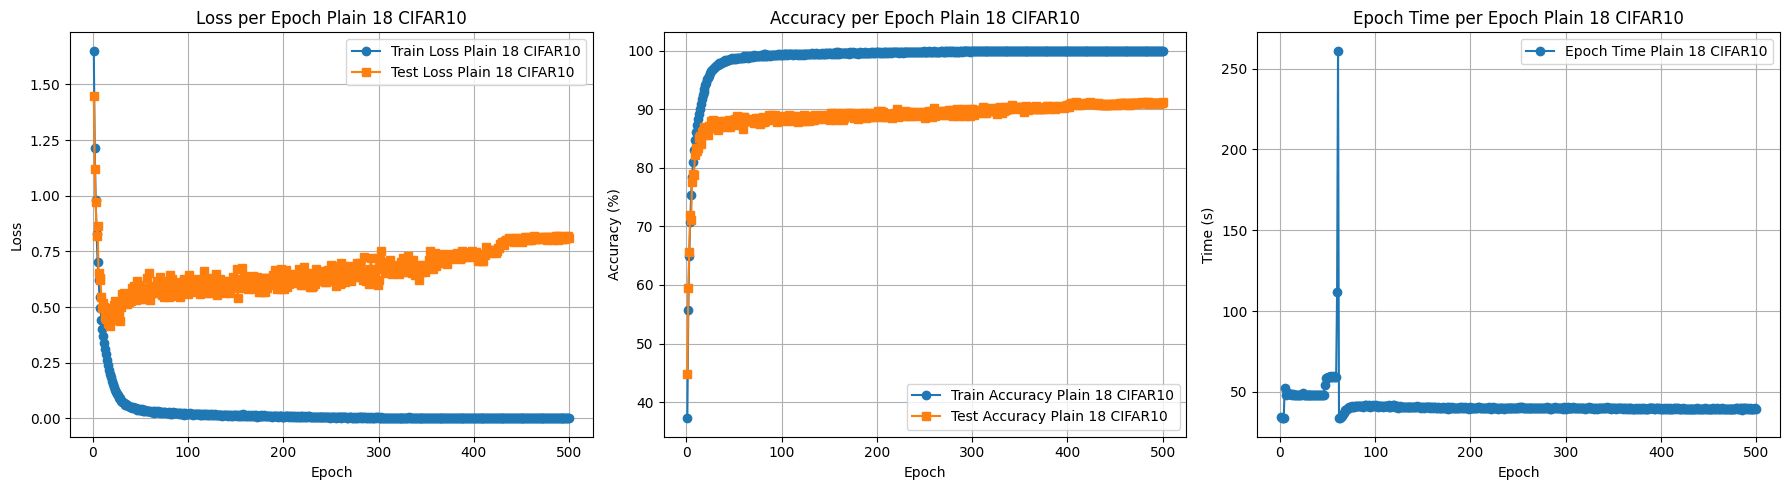

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/plain18_cifar10_metrics.csv"
df = pd.read_csv(url)

epoch_plain18_cifar10 = df["epoch"]
train_loss_plain18_cifar10 = df["train_loss"]
train_acc_plain18_cifar10 = df["train_acc"] * 100
test_loss_plain18_cifar10 = df["test_loss"]
test_acc_plain18_cifar10 = df["test_acc"] * 100
epoch_time_plain18_cifar10 = df["epoch_time"]

plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(epoch_plain18_cifar10, train_loss_plain18_cifar10, marker='o', label="Train Loss Plain 18 CIFAR10")
plt.plot(epoch_plain18_cifar10, test_loss_plain18_cifar10, marker='s', label="Test Loss Plain 18 CIFAR10")
plt.title("Loss per Epoch Plain 18 CIFAR10")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot(epoch_plain18_cifar10, train_acc_plain18_cifar10, marker='o', label="Train Accuracy Plain 18 CIFAR10")
plt.plot(epoch_plain18_cifar10, test_acc_plain18_cifar10, marker='s', label="Test Accuracy Plain 18 CIFAR10")
plt.title("Accuracy per Epoch Plain 18 CIFAR10")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# Epoch Time
plt.subplot(1,3,3)
plt.plot(epoch_plain18_cifar10, epoch_time_plain18_cifar10, marker='o', label="Epoch Time Plain 18 CIFAR10")
plt.title("Epoch Time per Epoch Plain 18 CIFAR10")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()  # adjust spacing to prevent overlap
plt.show()


In [ ]:
# Best Train Accuracy
best_train_acc = train_acc_plain18_cifar10.max()
best_train_acc_epoch = epoch_plain18_cifar10[train_acc_plain18_cifar10.idxmax()]

# Best Test Accuracy
best_test_acc = test_acc_plain18_cifar10.max()
best_test_acc_epoch = epoch_plain18_cifar10[test_acc_plain18_cifar10.idxmax()]

# Lowest Train Loss
best_train_loss = train_loss_plain18_cifar10.min()
best_train_loss_epoch = epoch_plain18_cifar10[train_loss_plain18_cifar10.idxmin()]

# Lowest Test Loss
best_test_loss = test_loss_plain18_cifar10.min()
best_test_loss_epoch = epoch_plain18_cifar10[test_loss_plain18_cifar10.idxmin()]

print(f"Best Train Accuracy: {best_train_acc:.2f}% at epoch {best_train_acc_epoch}")
print(f"Best Test Accuracy: {best_test_acc:.2f}% at epoch {best_test_acc_epoch}")
print(f"Lowest Train Loss: {best_train_loss:.4f} at epoch {best_train_loss_epoch}")
print(f"Lowest Test Loss: {best_test_loss:.4f} at epoch {best_test_loss_epoch}")
# First occurence of the best value

Best Train Accuracy: 100.00% at epoch 380
Best Test Accuracy: 91.27% at epoch 409
Lowest Train Loss: 0.0000 at epoch 484
Lowest Test Loss: 0.4165 at epoch 18


**Talk about the results here and try to link it to then having more layers using harry section. Also change the text to not talk about the food 101 bc we train on cifar but then what would happen if we trained it on the food.**

For moderate depths, such as our 18-layer baseline, adding layers generally improves performance because the network can learn more complex and abstract features. However, as networks become very deep, simply stacking more layers does not always help and can even make training harder. This is due to degradation, which occurs when gradients vanish or explode during backpropagation. When gradients vanish, early layers receive very small updates and learn very slowly, and when gradients explode, updates become unstable, which can cause training to fail. This shows that while deeper networks have more capacity, there are practical limits to how far we can increase depth without careful design or training strategies.

## Residual 18-layer CNN (ResNet-18)
We train the ResNet18 model using the same setup as the plain 18-layer CNN, but the architecture differs. We introduce residual blocks, where each block has two convolutional layers and a shortcut connection that allows the input to bypass the convolutions and be added to the output. This makes training more stable because the shortcut provides a direct path for gradients to flow backward. Even if gradients through the convolutional layers vanish or explode, the shortcut ensures that the gradient signal reaching earlier layers is preserved. This reduces the risk of training degradation and allows the network to take full advantage of the added depth, learning more complex features. The code is largely the same as before, but the network is now shorter and more efficient, as we use the same number of layers but incorporate residual connections.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Residual Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)   # residual connection
        out = F.relu(out)
        return out

# ResNet18 - residual
class ResNet18(nn.Module):
    def __init__(self, num_classes=101):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride))
        self.in_planes = planes * BasicBlock.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out



Again, the ResNet18 model was trained from scratch on Food101. All weights were randomly initialized, and the full network was optimized without using pretrained weights. The code for the training loop, can be found in [Report -> Supplementary -> training loops](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_loops/Resnet18_from_scratch_food101.py).


### Results for CIFAR-10


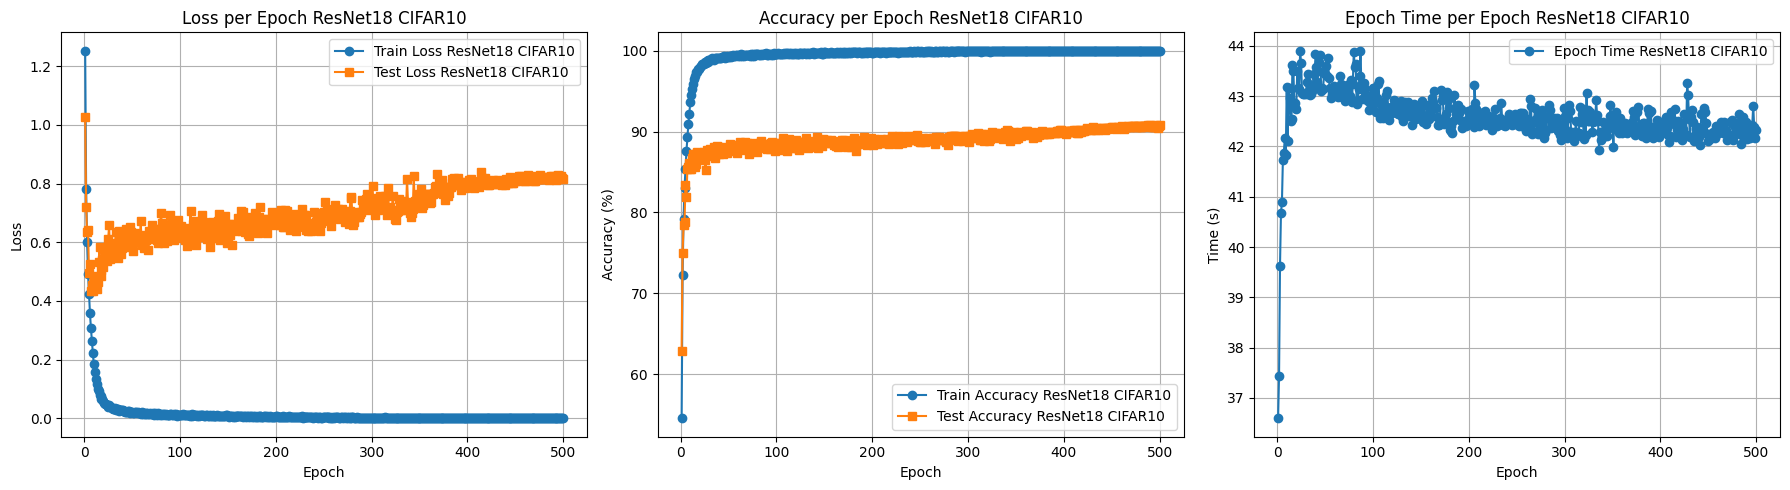

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ResNet18 CIFAR-10 metrics
url = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/resnet18_cifar10_metrics.csv"
df = pd.read_csv(url)

epoch_resnet18_cifar10 = df["epoch"]
train_loss_resnet18_cifar10 = df["train_loss"]
train_acc_resnet18_cifar10 = df["train_acc"] * 100
test_loss_resnet18_cifar10 = df["test_loss"]
test_acc_resnet18_cifar10 = df["test_acc"] * 100
epoch_time_resnet18_cifar10 = df["epoch_time"]

plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(epoch_resnet18_cifar10, train_loss_resnet18_cifar10, marker='o', label="Train Loss ResNet18 CIFAR10")
plt.plot(epoch_resnet18_cifar10, test_loss_resnet18_cifar10, marker='s', label="Test Loss ResNet18 CIFAR10")
plt.title("Loss per Epoch ResNet18 CIFAR10")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot(epoch_resnet18_cifar10, train_acc_resnet18_cifar10, marker='o', label="Train Accuracy ResNet18 CIFAR10")
plt.plot(epoch_resnet18_cifar10, test_acc_resnet18_cifar10, marker='s', label="Test Accuracy ResNet18 CIFAR10")
plt.title("Accuracy per Epoch ResNet18 CIFAR10")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# Epoch Time
plt.subplot(1,3,3)
plt.plot(epoch_resnet18_cifar10, epoch_time_resnet18_cifar10, marker='o', label="Epoch Time ResNet18 CIFAR10")
plt.title("Epoch Time per Epoch ResNet18 CIFAR10")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Best Train Accuracy
best_train_acc = train_acc_resnet18_cifar10.max()
best_train_acc_epoch = epoch_resnet18_cifar10[train_acc_resnet18_cifar10.idxmax()]

# Best Test Accuracy
best_test_acc = test_acc_resnet18_cifar10.max()
best_test_acc_epoch = epoch_resnet18_cifar10[test_acc_resnet18_cifar10.idxmax()]

# Lowest Train Loss
best_train_loss = train_loss_resnet18_cifar10.min()
best_train_loss_epoch = epoch_resnet18_cifar10[train_loss_resnet18_cifar10.idxmin()]

# Lowest Test Loss
best_test_loss = test_loss_resnet18_cifar10.min()
best_test_loss_epoch = epoch_resnet18_cifar10[test_loss_resnet18_cifar10.idxmin()]

print(f"Best Train Accuracy: {best_train_acc:.2f}% at epoch {best_train_acc_epoch}")
print(f"Best Test Accuracy: {best_test_acc:.2f}% at epoch {best_test_acc_epoch}")
print(f"Lowest Train Loss: {best_train_loss:.4f} at epoch {best_train_loss_epoch}")
print(f"Lowest Test Loss: {best_test_loss:.4f} at epoch {best_test_loss_epoch}")


Best Train Accuracy: 100.00% at epoch 341
Best Test Accuracy: 90.79% at epoch 496
Lowest Train Loss: 0.0000 at epoch 485
Lowest Test Loss: 0.4339 at epoch 9


### Results for Food-101


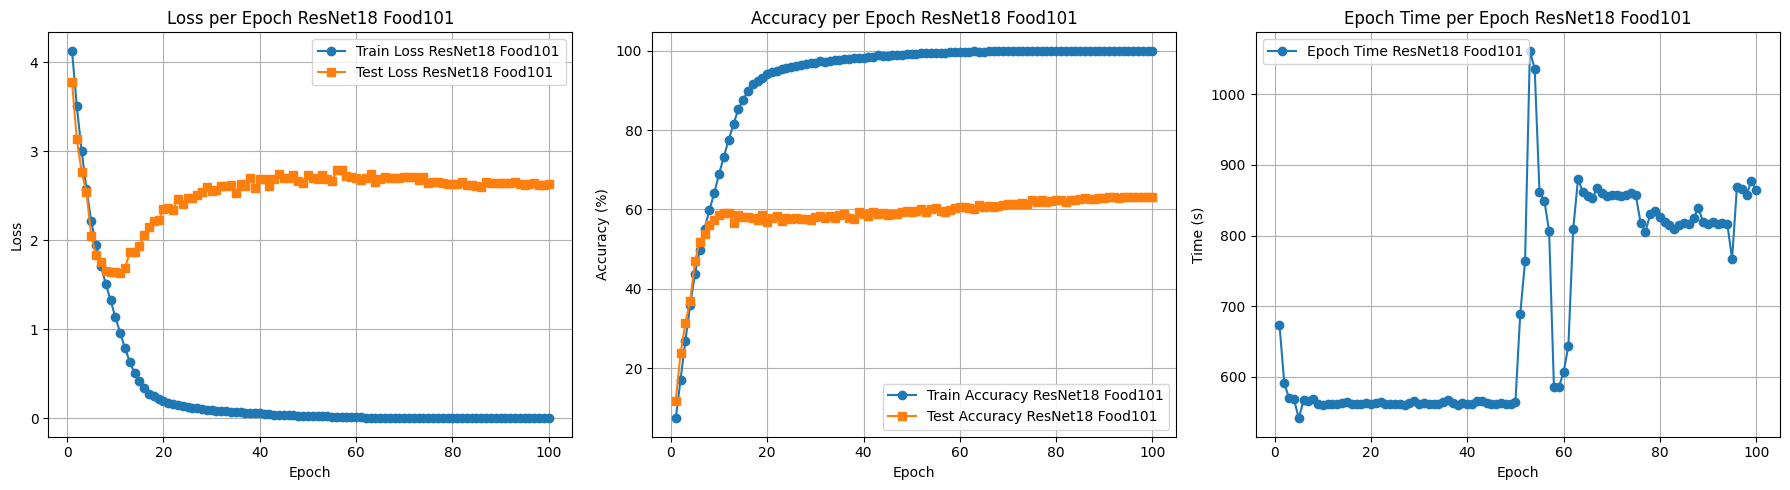

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ResNet18 Food101 metrics
url = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/resnet18_food101_metrics.csv"
df = pd.read_csv(url)

epoch_resnet18_food101 = df["epoch"]
train_loss_resnet18_food101 = df["train_loss"]
train_acc_resnet18_food101 = df["train_acc"] * 100
test_loss_resnet18_food101 = df["test_loss"]
test_acc_resnet18_food101 = df["test_acc"] * 100
epoch_time_resnet18_food101 = df["epoch_time"]

plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(epoch_resnet18_food101, train_loss_resnet18_food101, marker='o', label="Train Loss ResNet18 Food101")
plt.plot(epoch_resnet18_food101, test_loss_resnet18_food101, marker='s', label="Test Loss ResNet18 Food101")
plt.title("Loss per Epoch ResNet18 Food101")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot(epoch_resnet18_food101, train_acc_resnet18_food101, marker='o', label="Train Accuracy ResNet18 Food101")
plt.plot(epoch_resnet18_food101, test_acc_resnet18_food101, marker='s', label="Test Accuracy ResNet18 Food101")
plt.title("Accuracy per Epoch ResNet18 Food101")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# Epoch Time
plt.subplot(1,3,3)
plt.plot(epoch_resnet18_food101, epoch_time_resnet18_food101, marker='o', label="Epoch Time ResNet18 Food101")
plt.title("Epoch Time per Epoch ResNet18 Food101")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Best Train Accuracy
best_train_acc = train_acc_resnet18_food101.max()
best_train_acc_epoch = epoch_resnet18_food101[train_acc_resnet18_food101.idxmax()]

# Best Test Accuracy
best_test_acc = test_acc_resnet18_food101.max()
best_test_acc_epoch = epoch_resnet18_food101[test_acc_resnet18_food101.idxmax()]

# Lowest Train Loss
best_train_loss = train_loss_resnet18_food101.min()
best_train_loss_epoch = epoch_resnet18_food101[train_loss_resnet18_food101.idxmin()]

# Lowest Test Loss
best_test_loss = test_loss_resnet18_food101.min()
best_test_loss_epoch = epoch_resnet18_food101[test_loss_resnet18_food101.idxmin()]

print(f"Best Train Accuracy: {best_train_acc:.2f}% at epoch {best_train_acc_epoch}")
print(f"Best Test Accuracy: {best_test_acc:.2f}% at epoch {best_test_acc_epoch}")
print(f"Lowest Train Loss: {best_train_loss:.4f} at epoch {best_train_loss_epoch}")
print(f"Lowest Test Loss: {best_test_loss:.4f} at epoch {best_test_loss_epoch}")


Best Train Accuracy: 100.00% at epoch 96
Best Test Accuracy: 63.20% at epoch 97
Lowest Train Loss: 0.0001 at epoch 99
Lowest Test Loss: 1.6290 at epoch 11


## Pretrained ResNet 18
Pre-trained models are neural networks that have already been trained on large datasets for a general task such as image classification. Using a pre-trained model allows us to leverage the features it has already learned, like edges, textures, and higher-level patterns, rather than training a network from scratch. This can save a lot of time and computational resources, and it often improves performance, especially when the dataset for the target task is smaller or limited.

However, pre-trained models are not always perfectly suited to every task. If the new dataset is very different from the dataset used for pre-training, the learned features may not fully capture the relevant patterns, which can limit performance. Additionally, large pre-trained networks can be computationally demanding and require significant memory, which may be a practical limitation depending on available hardware.

In this work, we focus on ResNet-18 as our pre-trained model. ResNet-18 is a residual network trained on ImageNet, a large dataset containing over a million images across 1,000 categories of everyday objects, animals, and scenes. The model has learned general visual features that can be applied to many tasks, including food classification. In this section, we explore how to adapt ResNet-18 for the Food-101 dataset using feature extraction and fine-tuning, two common approaches in transfer learning that allow the model to leverage its pre-trained knowledge while adapting to a new task.



### Feature extraction
For this experiment, we keep the same training setup and parameters as before, including batch size, epochs, loss, and optimizer. The main change is that we freeze all pre-trained ResNet-18 layers and only train the final fully connected layer, which is adjusted to output 101 classes for Food-101. This reduces the number of trainable parameters, making training faster and more stable, while still taking advantage of the rich feature representations learned from ImageNet. Using the same setup allows a direct comparison with our other models and demonstrates the benefits of transfer learning.

The training code for CIFAR-10 can be found [`Supplementary -> training_loops -> transfer_learning_resnet18`](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_loops/transfer_learning_resnet18.py).  

The training code for Food101 can be found [`Supplementary -> training_loops -> transfer_resnet18_food101`](https://github.com/K-Chorna02/DST_Assessment_2/blob/main/Report/Supplementary/training_loops/transfer_resnet18_food101.py).


#### Results for CIFAR-10

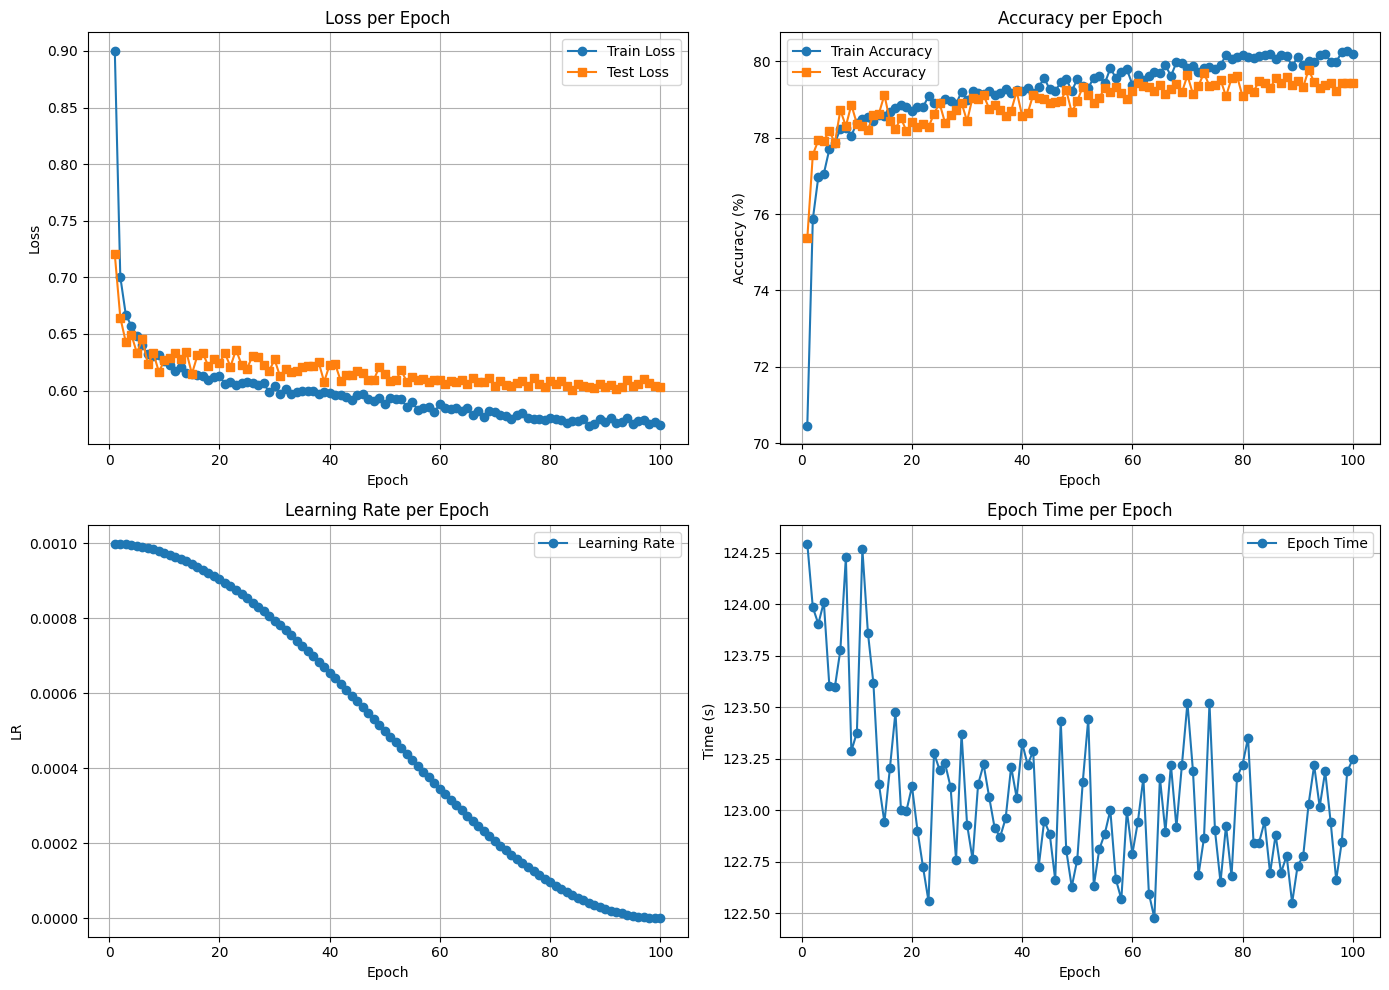

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ResNet18 CIFAR-10 metrics (feature extraction)
url = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/resnet18_cifar10_transfer_metrics.csv"
df = pd.read_csv(url)

epoch_pretrainedresnet18_cifar10_fe = df["epoch"]
train_loss_pretrainedresnet18_cifar10_fe = df["train_loss"]
train_acc_pretrainedresnet18_cifar10_fe = df["train_acc"] * 100
test_loss_pretrainedresnet18_cifar10_fe = df["test_loss"]
test_acc_pretrainedresnet18_cifar10_fe = df["test_acc"] * 100
lr_pretrainedresnet18_cifar10_fe = df["lr"]
epoch_time_pretrainedresnet18_cifar10_fe = df["epoch_time"]

plt.figure(figsize=(14,10))

# Loss
plt.subplot(2,2,1)
plt.plot(epoch_pretrainedresnet18_cifar10_fe, train_loss_pretrainedresnet18_cifar10_fe, marker='o', label="Train Loss")
plt.plot(epoch_pretrainedresnet18_cifar10_fe, test_loss_pretrainedresnet18_cifar10_fe, marker='s', label="Test Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(2,2,2)
plt.plot(epoch_pretrainedresnet18_cifar10_fe, train_acc_pretrainedresnet18_cifar10_fe, marker='o', label="Train Accuracy")
plt.plot(epoch_pretrainedresnet18_cifar10_fe, test_acc_pretrainedresnet18_cifar10_fe, marker='s', label="Test Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# Learning Rate
plt.subplot(2,2,3)
plt.plot(epoch_pretrainedresnet18_cifar10_fe, lr_pretrainedresnet18_cifar10_fe, marker='o', label="Learning Rate")
plt.title("Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)
plt.legend()

# Epoch Time
plt.subplot(2,2,4)
plt.plot(epoch_pretrainedresnet18_cifar10_fe, epoch_time_pretrainedresnet18_cifar10_fe, marker='o', label="Epoch Time")
plt.title("Epoch Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Best Train Accuracy
best_train_acc = train_acc_pretrainedresnet18_cifar10_fe.max()
best_train_acc_epoch = epoch_pretrainedresnet18_cifar10_fe[
    train_acc_pretrainedresnet18_cifar10_fe.idxmax()
]

# Best Test Accuracy
best_test_acc = test_acc_pretrainedresnet18_cifar10_fe.max()
best_test_acc_epoch = epoch_pretrainedresnet18_cifar10_fe[
    test_acc_pretrainedresnet18_cifar10_fe.idxmax()
]

# Lowest Train Loss
best_train_loss = train_loss_pretrainedresnet18_cifar10_fe.min()
best_train_loss_epoch = epoch_pretrainedresnet18_cifar10_fe[
    train_loss_pretrainedresnet18_cifar10_fe.idxmin()
]

# Lowest Test Loss
best_test_loss = test_loss_pretrainedresnet18_cifar10_fe.min()
best_test_loss_epoch = epoch_pretrainedresnet18_cifar10_fe[
    test_loss_pretrainedresnet18_cifar10_fe.idxmin()
]

print(f"Best Train Accuracy: {best_train_acc:.2f}% at epoch {best_train_acc_epoch}")
print(f"Best Test Accuracy: {best_test_acc:.2f}% at epoch {best_test_acc_epoch}")
print(f"Lowest Train Loss: {best_train_loss:.4f} at epoch {best_train_loss_epoch}")
print(f"Lowest Test Loss: {best_test_loss:.4f} at epoch {best_test_loss_epoch}")


Best Train Accuracy: 80.27% at epoch 99
Best Test Accuracy: 79.78% at epoch 92
Lowest Train Loss: 0.5692 at epoch 87
Lowest Test Loss: 0.6004 at epoch 84


#### Results for Food-101


We use the original resolution on 64x 64 thtas whyt its so good explain...

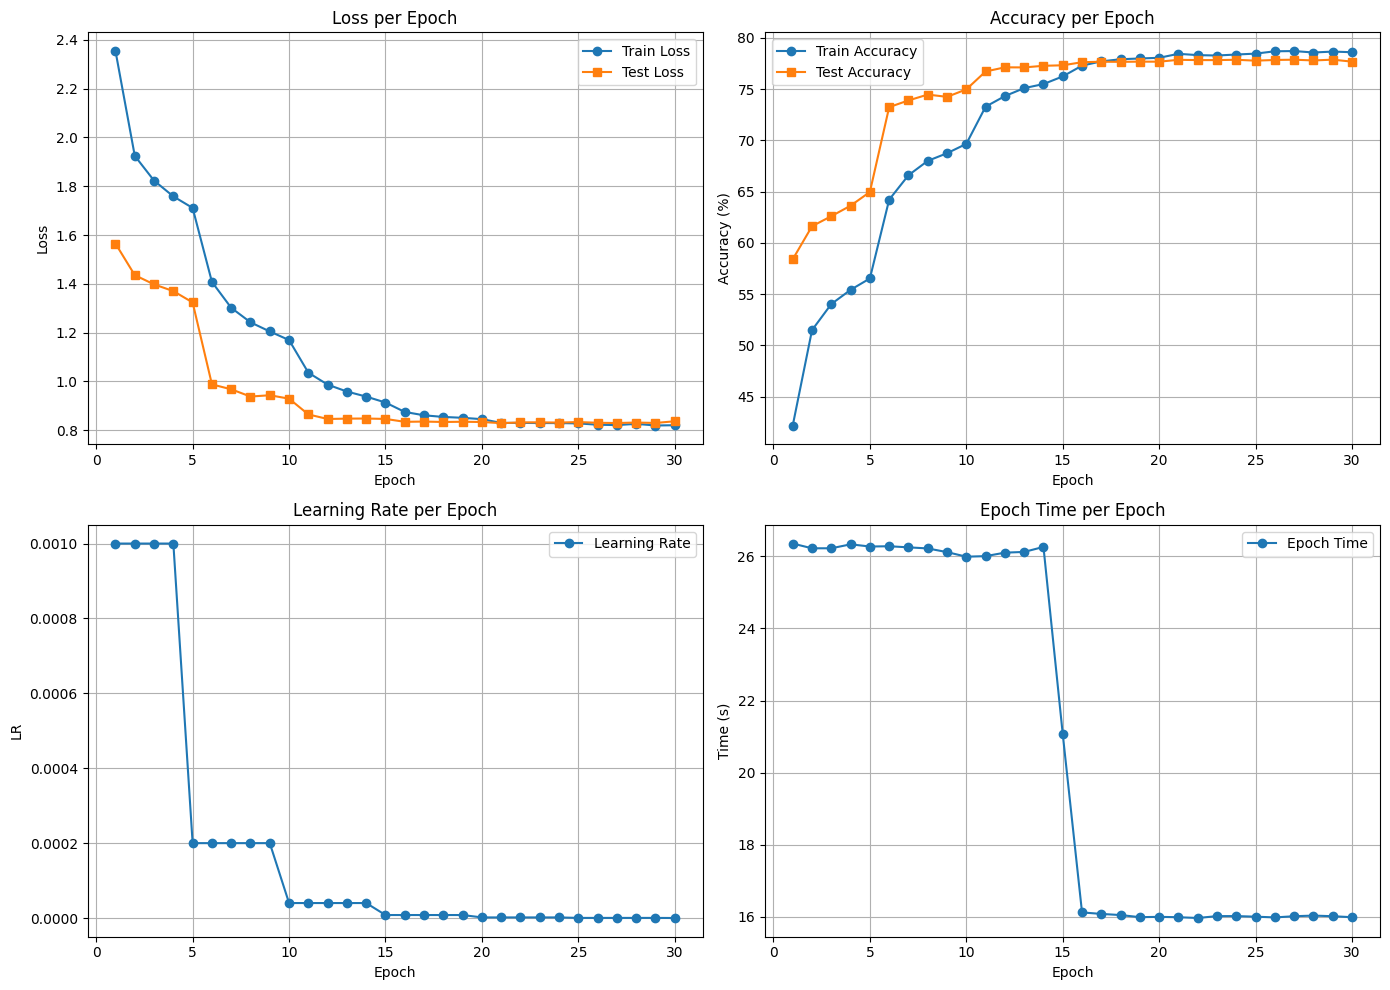

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ResNet18 Food101 metrics (feature extraction)
url = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/food101_resnet18_kaggle_style_log.csv"
df = pd.read_csv(url)

epoch_pretrainedresnet18_food101_fe = df["epoch"]
train_loss_pretrainedresnet18_food101_fe = df["train_loss"]
train_acc_pretrainedresnet18_food101_fe = df["train_acc"]
test_loss_pretrainedresnet18_food101_fe = df["val_loss"]
test_acc_pretrainedresnet18_food101_fe = df["val_acc"]
lr_pretrainedresnet18_food101_fe = df["lr"]
epoch_time_pretrainedresnet18_food101_fe = df["epoch_time"]

plt.figure(figsize=(14,10))

# Loss
plt.subplot(2,2,1)
plt.plot(epoch_pretrainedresnet18_food101_fe, train_loss_pretrainedresnet18_food101_fe, marker='o', label="Train Loss")
plt.plot(epoch_pretrainedresnet18_food101_fe, test_loss_pretrainedresnet18_food101_fe, marker='s', label="Test Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(2,2,2)
plt.plot(epoch_pretrainedresnet18_food101_fe, train_acc_pretrainedresnet18_food101_fe, marker='o', label="Train Accuracy")
plt.plot(epoch_pretrainedresnet18_food101_fe, test_acc_pretrainedresnet18_food101_fe, marker='s', label="Test Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# Learning Rate
plt.subplot(2,2,3)
plt.plot(epoch_pretrainedresnet18_food101_fe, lr_pretrainedresnet18_food101_fe, marker='o', label="Learning Rate")
plt.title("Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)
plt.legend()

# Epoch Time
plt.subplot(2,2,4)
plt.plot(epoch_pretrainedresnet18_food101_fe, epoch_time_pretrainedresnet18_food101_fe, marker='o', label="Epoch Time")
plt.title("Epoch Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Best Train Accuracy
best_train_acc = train_acc_pretrainedresnet18_food101_fe.max()
best_train_acc_epoch = epoch_pretrainedresnet18_food101_fe[
    train_acc_pretrainedresnet18_food101_fe.idxmax()
]

# Best Test Accuracy
best_test_acc = test_acc_pretrainedresnet18_food101_fe.max()
best_test_acc_epoch = epoch_pretrainedresnet18_food101_fe[
    test_acc_pretrainedresnet18_food101_fe.idxmax()
]

# Lowest Train Loss
best_train_loss = train_loss_pretrainedresnet18_food101_fe.min()
best_train_loss_epoch = epoch_pretrainedresnet18_food101_fe[
    train_loss_pretrainedresnet18_food101_fe.idxmin()
]

# Lowest Test Loss
best_test_loss = test_loss_pretrainedresnet18_food101_fe.min()
best_test_loss_epoch = epoch_pretrainedresnet18_food101_fe[
    test_loss_pretrainedresnet18_food101_fe.idxmin()
]

print(f"Best Train Accuracy: {best_train_acc:.2f}% at epoch {best_train_acc_epoch}")
print(f"Best Test Accuracy: {best_test_acc:.2f}% at epoch {best_test_acc_epoch}")
print(f"Lowest Train Loss: {best_train_loss:.4f} at epoch {best_train_loss_epoch}")
print(f"Lowest Test Loss: {best_test_loss:.4f} at epoch {best_test_loss_epoch}")


Best Train Accuracy: 78.70% at epoch 27
Best Test Accuracy: 77.86% at epoch 29
Lowest Train Loss: 0.8196 at epoch 29
Lowest Test Loss: 0.8292 at epoch 21


### Fine tuning
Fine-tuning is another way to use a pre-trained model, such as ResNet-18 trained on ImageNet, where we allow more of its layers to be updated when training on a new dataset. Unlike feature extraction, where only the final classifier is trained, fine-tuning lets the network adjust its pre-trained weights to better fit the new data. This can improve performance, particularly when the target dataset differs from the one used for pre-training.

The lower layers of a convolutional network typically capture general features such as edges, textures, and shapes, which are broadly useful across tasks, while higher layers focus on patterns specific to the original task. By fine-tuning, we allow the weights in some or all layers to change, enabling the network to adapt to the new task. The trade-offs include increased computation, longer training times, and the need for a lower learning rate to prevent overwriting useful pre-trained weights too quickly.

For CIFAR-10, we perform partial fine-tuning by freezing the early layers of ResNet-18 specifically layer1 and layer2, which together contain 8 convolutional layers—and only updating the deeper layers (layer3 and layer4) and the final classifier. This approach allows the network to learn dataset-specific features while retaining general features learned from ImageNet. In this section, we explore partial fine-tuning on CIFAR-10 and compare it with feature extraction to see how adjusting pre-trained weights affects model performance.

#### Results for CIFAR-10

**ADD results here**

## Vision Transformer
Vision Transformer (ViT) extend the Transformer architecture originally intrduced in 'Attention is all you need' (link) used in language processing to image recognition task. Instead of using convolutional kernels, ViT divides image into fixed-size patches, embeds each patch sa a token and process the resulting sequence using standard self-attention layers. Unlike, traditional CNN which captures global structure of an image using a kernel which is limited by the size of the kernel, ViT model patches division allow the model to captures the dependencies between pixel much further apart without over generalisation.

# Preliminary

Suppose we have an input image $x\in \mathbb{R}^{(H,W,C)}$, where H,W,C correspond to height, weight and channel (i.e. RGB) respectively. For each channel, ViT first divide the image within the channel into patches, then within each patch the image is flattened into a sequence of vectors containing the pixel values within their respective patches. This is denoted by
$$
P(X) = [x_1,...,x_N]
$$
where $x_i \in \mathbb{R}^{P^2C}$ is the flatten vector on the $i^{th}$ patch, P is patch size and $N =HW/P^2$ is the number of patches. Then, each patch is linearly project onto a space of hidden dimension in the transformer encoder. This process is called tokenization denote by

$$
T(x) = P(x)E_t
$$

where $E_t \in \mathbb{R}^{(P^2C) \times d}$ is the tokenization matrix with hidden dimension $d$. Then, the learnable class token is $x_{cls}\in\mathbb{R}^{d}$ is prepend to the vectors and the positional embeding $E_{pos} \in \mathbb{R}^{(N+1) \times d}$ is summed forming,

$$
z_0(x) = [x_{cls};T(x)] + E_{pos}.
$$
This token is then act as an input into the transformer encoder. In the original paper the ViT transformer encoder consist of alternating layer of multiheaded self-attension(MSA) and multi layer perceptron (MLP). Here MLP contains  small 2 layer neural network with each sub layer containing linear layer and (GELU) activation map. Between each layer of MSA and MLP a Layernorm(LN) is applied and residual is summed similar to Resnet architechture. This process is described below,

$$
z'_l = MSA(LN(z_{l-1})) + z_{l-1} \quad l=1,\dots,L,
$$
$$
z_l = MLP(LN(z'_l)) + z'_l \quad l = 1,\dots, L,
$$
$$
y = LN(z_L^0).
$$

Finally, we dicuss the self attention layer within MSA layer works by first introducing three learnable matrix called Query, Key, and Value denoted by $E_q, E_k, E_v$ where the dimension for $E_q$ and $E_k$ is $\mathbb{R}^{d \times d_s}$ while dimension for E_v is$. The attention score matrix $R \in \mathbb{R}^{((N+1)\times (N+1))}$ is then defined as:

$$
R(z) = zE_q(zE_k)^T.
$$

Here the diagonal entries for $R$ is represents self token relation while, off diagonal entries represent inter token relations. We then compute the output by dividing the $R$ with $d_s$ and put it through softmax function and the dot product between,

$$
SA(z) = softmax(\frac{R(z)}{\sqrt{d_s}})xE_v
$$

The MSA layer is simply multiple SA layer inparallel where we contatinates the SA layer and linearly projecting it. The full detail is given in the original paper



## ViT for small data set

It has been shown that Vision Transformers often struggle on small datasets because they lack the locality inductive bias that CNNs naturally possess. Convolutional networks typically begin with small, overlapping receptive fields that encode local textures and gradually expand to capture global structure. ViT, on the other hands, start with a small receptive field equivalent to a non overlapping kernel with size equal to patch size (16x16 in original paper). This means that ViT must learn locality information entirely from the data, which explains the underperformance for small dataset.

## LSA & SPT

In order to tackle these limitation on small datasets, we implimented the augmentation for ViT specifically designed for small dataset introduced in (link). The first augmentation we use is Shifted Patch Tokenization(SPT). This augmentation is done by first shifting the image by half a patch size, in 4 direction (up,down,left,right) then concatenated it back to the original image as new channels. This result in $C_{shifted} = C_{original} \times 5$, this modified tokenizasion is labeled as

$$
S(x) = LN(P([x,s_1,s_2,s_3,s_4]))E_S
$$

with $s_i \in \mathbb{R}^{(H\times W\times C)}$ is the shifted image and $E_S \in \mathbb{R}^{(P^2(5C)\times d}$ is the new linear projection with $d$ being the hidden dimension. this is implimented in our code as:

In [ ]:
class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

Another augmentation we have adopted is the Locality-self attention(LSA) adjustment of the self attention head. This is done by modifying the self-attention matrix $R$ by making the diagonal entry orresponding to the self token relation to negative infinity,

$$ R^{M}_{i,j}(x) =
\begin{cases}
R_{i,j}(x), & \text{if } i \neq j, \\
-\infty, & \text{if } i = j.
\end{cases}
$$

This encourage the model to emphasize inter relation token instead through soft max function. Additionally, the output for the self attention is modified so that $R$ is now divided by a learnable parameter $\tau$ instead of dimension $d_s$. This have been shown to sharpen the distribution of the self-attension matrix and therefore make the attension matrix more discriminative of unimportant tokens. and so the LSA is defined by,

$$
L(z) = softmax(\frac{R^M(z)}{\tau}zE_v)
$$

In [ ]:
class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

Most of the implimentation is heavily based on (https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_for_small_dataset.py)

### Result for Cifar-10



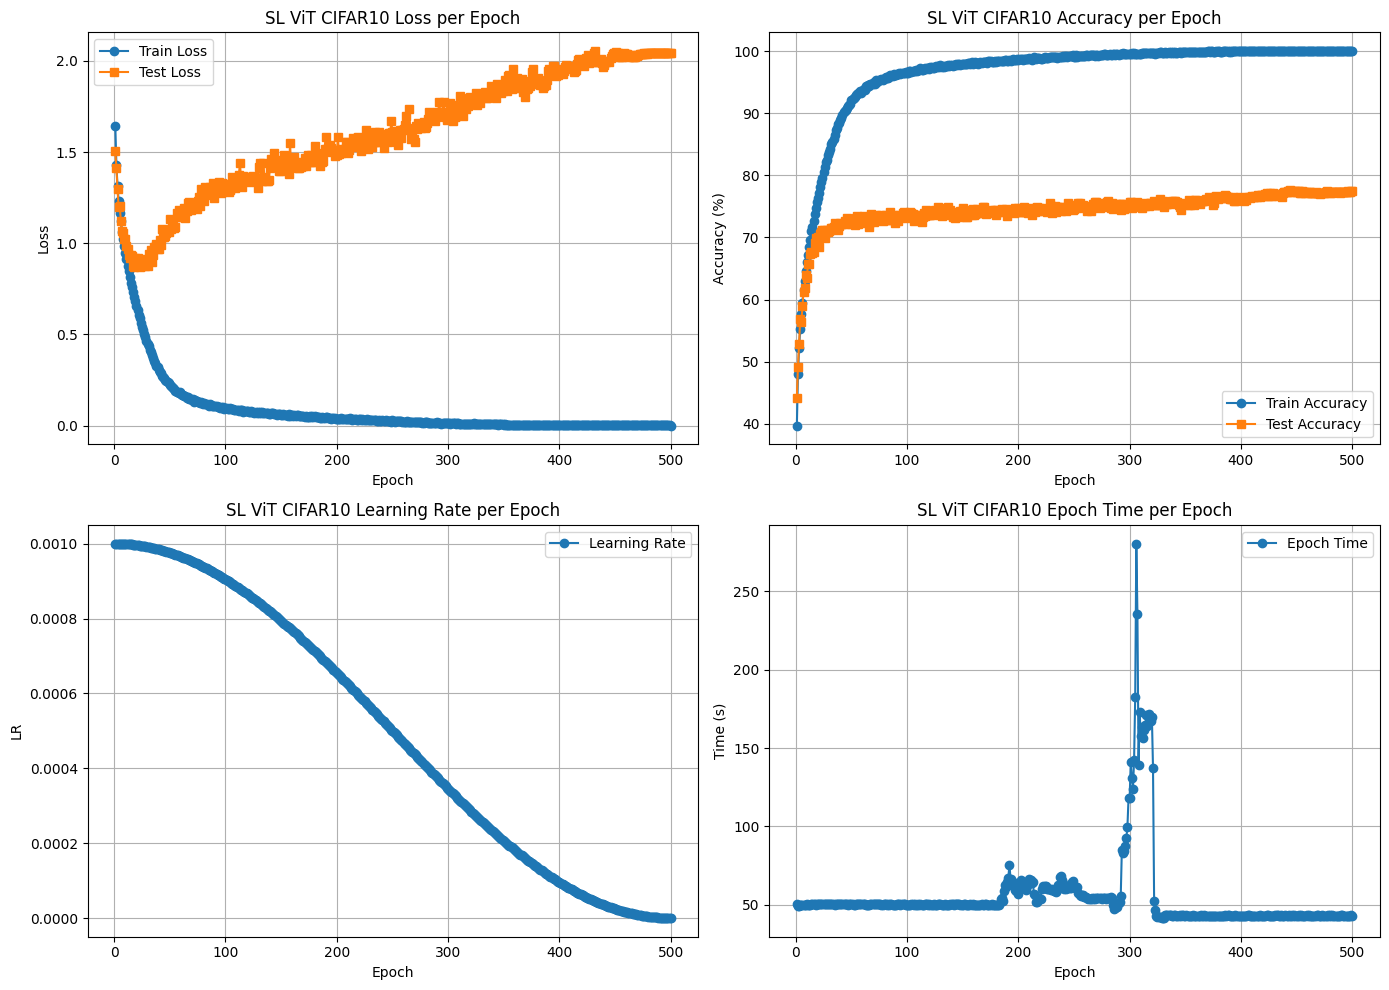

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load SL ViT CIFAR10 metrics
url = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/slvit_cifar10_metrics.csv"
df = pd.read_csv(url)

epoch_vit_cifar10 = df["epoch"]
train_loss_vit_cifar10 = df["train_loss"]
train_acc_vit_cifar10 = df["train_acc"] * 100
test_loss_vit_cifar10 = df["test_loss"]
test_acc_vit_cifar10 = df["test_acc"] * 100
lr_vit_cifar10 = df["lr"]
epoch_time_vit_cifar10 = df["epoch_time"]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epoch_vit_cifar10, train_loss_vit_cifar10, marker='o', label="Train Loss")
plt.plot(epoch_vit_cifar10, test_loss_vit_cifar10, marker='s', label="Test Loss")
plt.title("SL ViT CIFAR10 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epoch_vit_cifar10, train_acc_vit_cifar10, marker='o', label="Train Accuracy")
plt.plot(epoch_vit_cifar10, test_acc_vit_cifar10, marker='s', label="Test Accuracy")
plt.title("SL ViT CIFAR10 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epoch_vit_cifar10, lr_vit_cifar10, marker='o', label="Learning Rate")
plt.title("SL ViT CIFAR10 Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epoch_vit_cifar10, epoch_time_vit_cifar10, marker='o', label="Epoch Time")
plt.title("SL ViT CIFAR10 Epoch Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Best Train Accuracy
best_train_acc_vit_cifar10 = train_acc_vit_cifar10.max()
best_train_acc_epoch_vit_cifar10 = epoch_vit_cifar10[
    train_acc_vit_cifar10.idxmax()
]

# Best Test Accuracy
best_test_acc_vit_cifar10 = test_acc_vit_cifar10.max()
best_test_acc_epoch_vit_cifar10 = epoch_vit_cifar10[
    test_acc_vit_cifar10.idxmax()
]

# Lowest Train Loss
best_train_loss_vit_cifar10 = train_loss_vit_cifar10.min()
best_train_loss_epoch_vit_cifar10 = epoch_vit_cifar10[
    train_loss_vit_cifar10.idxmin()
]

# Lowest Test Loss
best_test_loss_vit_cifar10 = test_loss_vit_cifar10.min()
best_test_loss_epoch_vit_cifar10 = epoch_vit_cifar10[
    test_loss_vit_cifar10.idxmin()
]

print(f"Best Train Accuracy: {best_train_acc_vit_cifar10:.2f}% at epoch {best_train_acc_epoch_vit_cifar10}")
print(f"Best Test Accuracy: {best_test_acc_vit_cifar10:.2f}% at epoch {best_test_acc_epoch_vit_cifar10}")
print(f"Lowest Train Loss: {best_train_loss_vit_cifar10:.4f} at epoch {best_train_loss_epoch_vit_cifar10}")
print(f"Lowest Test Loss: {best_test_loss_vit_cifar10:.4f} at epoch {best_test_loss_epoch_vit_cifar10}")


Best Train Accuracy: 100.00% at epoch 466
Best Test Accuracy: 77.68% at epoch 444
Lowest Train Loss: 0.0000 at epoch 500
Lowest Test Loss: 0.8698 at epoch 18


### Results for Food-101

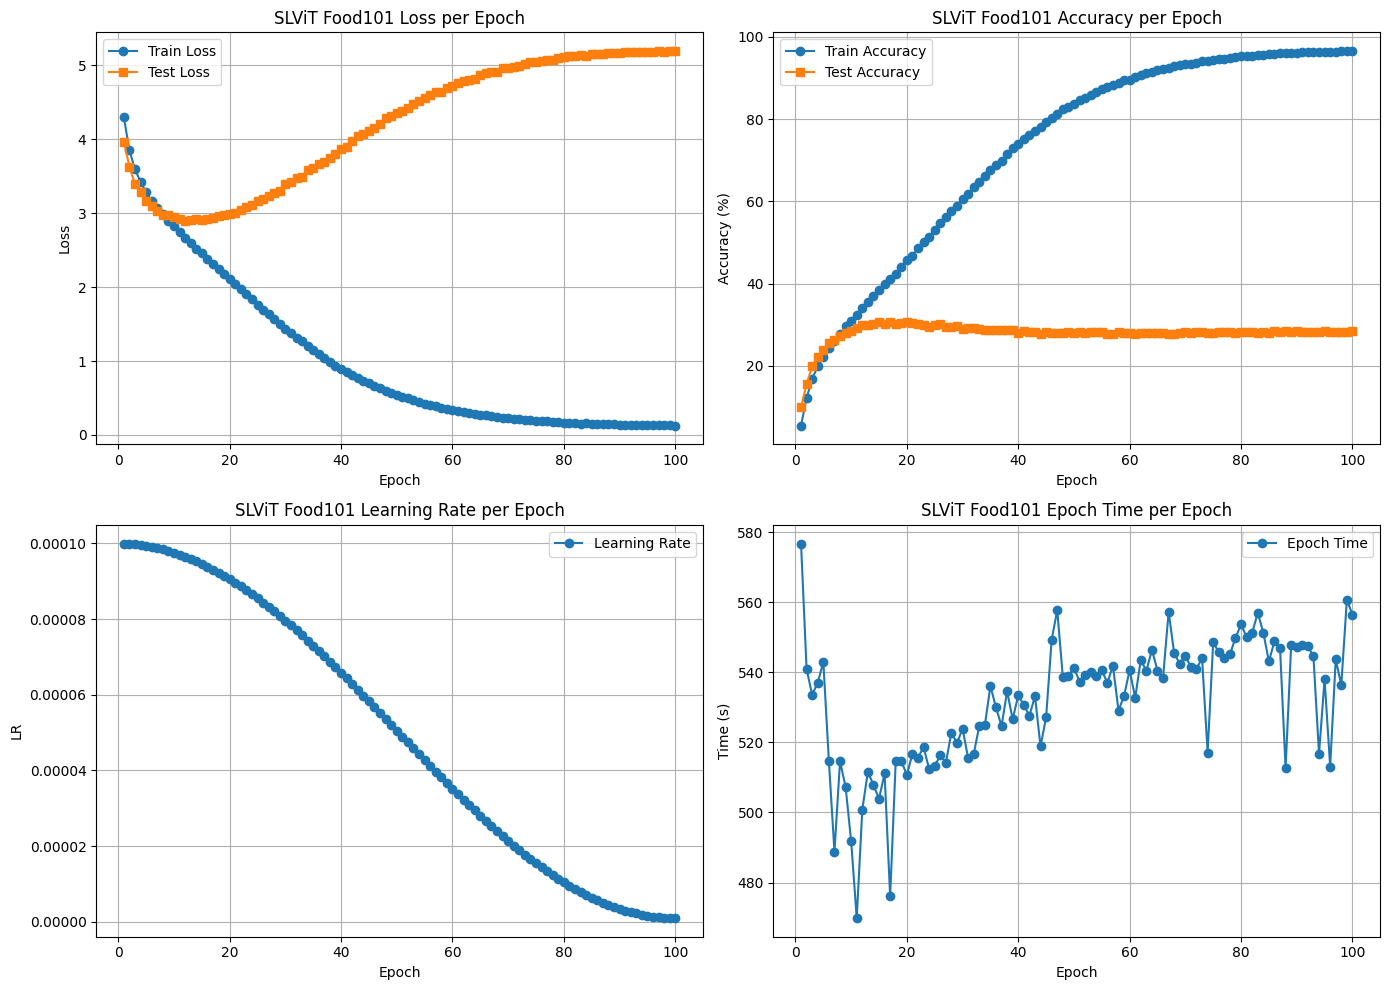

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load SL ViT Food101 metrics
url = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/results_graph/slvit_food101_metrics.csv"
df = pd.read_csv(url)

epoch_vit_food101 = df["epoch"]
train_loss_vit_food101 = df["train_loss"]
train_acc_vit_food101 = df["train_acc"] * 100
test_loss_vit_food101 = df["test_loss"]
test_acc_vit_food101 = df["test_acc"] * 100
lr_vit_food101 = df["lr"]
epoch_time_vit_food101 = df["epoch_time"]

plt.figure(figsize=(14, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(epoch_vit_food101, train_loss_vit_food101, marker='o', label="Train Loss")
plt.plot(epoch_vit_food101, test_loss_vit_food101, marker='s', label="Test Loss")
plt.title("SLViT Food101 Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(epoch_vit_food101, train_acc_vit_food101, marker='o', label="Train Accuracy")
plt.plot(epoch_vit_food101, test_acc_vit_food101, marker='s', label="Test Accuracy")
plt.title("SLViT Food101 Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

# Learning Rate
plt.subplot(2, 2, 3)
plt.plot(epoch_vit_food101, lr_vit_food101, marker='o', label="Learning Rate")
plt.title("SLViT Food101 Learning Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)
plt.legend()

# Epoch Time
plt.subplot(2, 2, 4)
plt.plot(epoch_vit_food101, epoch_time_vit_food101, marker='o', label="Epoch Time")
plt.title("SLViT Food101 Epoch Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Best Train Accuracy
best_train_acc_vit_food101 = train_acc_vit_food101.max()
best_train_acc_epoch_vit_food101 = epoch_vit_food101[
    train_acc_vit_food101.idxmax()
]

# Best Test Accuracy
best_test_acc_vit_food101 = test_acc_vit_food101.max()
best_test_acc_epoch_vit_food101 = epoch_vit_food101[
    test_acc_vit_food101.idxmax()
]

# Lowest Train Loss
best_train_loss_vit_food101 = train_loss_vit_food101.min()
best_train_loss_epoch_vit_food101 = epoch_vit_food101[
    train_loss_vit_food101.idxmin()
]

# Lowest Test Loss
best_test_loss_vit_food101 = test_loss_vit_food101.min()
best_test_loss_epoch_vit_food101 = epoch_vit_food101[
    test_loss_vit_food101.idxmin()
]

print(f"Best Train Accuracy: {best_train_acc_vit_food101:.2f}% at epoch {best_train_acc_epoch_vit_food101}")
print(f"Best Test Accuracy: {best_test_acc_vit_food101:.2f}% at epoch {best_test_acc_epoch_vit_food101}")
print(f"Lowest Train Loss: {best_train_loss_vit_food101:.4f} at epoch {best_train_loss_epoch_vit_food101}")
print(f"Lowest Test Loss: {best_test_loss_vit_food101:.4f} at epoch {best_test_loss_epoch_vit_food101}")


Best Train Accuracy: 96.58% at epoch 100
Best Test Accuracy: 30.74% at epoch 17
Lowest Train Loss: 0.1283 at epoch 100
Lowest Test Loss: 2.8985 at epoch 12


# Comparison

## Metrics
## Loss vs Accuracy

Loss measures how far off the model’s predictions are from the correct answers. In classification, cross-entropy loss is usually used. If $y_{i,c}$ is the true label for example $i$ and class $c$ (1 if correct, 0 otherwise), and $p_{i,c}$ is the predicted probability, the loss is:  

$$
L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})
$$

Smaller loss means the model is making predictions closer to the truth. For example, if the model predicts “cat” with 90% probability for an image that is actually a cat, the loss is low. If it predicts “dog” with 90% instead, the loss is high.  

Accuracy measures the fraction of predictions the model got exactly right. If $\hat{y}_i$ is the predicted class of example $i$, accuracy is:  

$$
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\hat{y}_i = y_i)
$$  

where $\mathbf{1}(\cdot)$ is 1 if the prediction is correct, 0 if not. Accuracy does not care how wrong the wrong predictions were.  

## Train vs Test Metrics
Train metrics, including loss and accuracy, show how well the model is learning from the data it is trained on. Low train loss and high train accuracy indicate that the model fits the training data well and is capturing the patterns present in that data.  

Test metrics, computed on unseen data, show how well the model generalises. They tell us whether the model can make accurate predictions on new examples it has never seen before.  

Comparing train and test metrics gives some insights about the model’s behavior. If test loss is higher and test accuracy is lower than train, the model is propably overfitting as it has memorized details of the training data that do not apply to new data. On the other hand, if test metrics are better than train metrics, it may indicate underfitting, or that the training data is noisier or more difficult than the test set.  



## Training from scratch

## Transfer learning

## Testing robustness
Now we have our pretrained models, it is important to test how robust they are to changes in the data.

After reading [2], we discovered a number of ways we could adjust our images to challenge the model.
We've modified the test set in the following way:

- Adding noise
- Brightness
- Defocus (Gaussian blur)
- Pixelate
- Fog attack
- Frost attack



In [50]:
#libraries just for robustness
import torch
import numpy as np
import cv2
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torch.nn.functional as F

We vary the severity of our robustness attacks in order to generate a clear visualisation of how severity affects the performance of our model.

In [51]:
SEVERITY_LEVELS = [1, 2, 3, 4, 5]
#adding noise
def add_noise(images, severity):
    noise_level = 0.05 * severity
    noise = torch.randn_like(images) * noise_level
    return torch.clamp(images + noise, -1, 1).float()

#brightness
def change_brightness(images, severity):
    factor = 1 - 0.15 * severity
    return torch.clamp(images * factor, -1, 1).float()

#gaussian blur
def defocus_blur(images, severity):
    kernel_size = 2 * severity + 1
    blurred = []
    for img in images:
        npimg = img.permute(1,2,0).cpu().numpy()
        npimg_blur = cv2.GaussianBlur(npimg, (kernel_size, kernel_size), 0)
        blurred.append(torch.tensor(npimg_blur).permute(2,0,1))
    return torch.stack(blurred).clamp(-1,1).float()

#pixelate
def pixelate(images, severity):
    scale_down = 2 + severity * 2
    pixelated = []
    for img in images:
        npimg = img.permute(1,2,0).cpu().numpy()
        h, w = npimg.shape[:2]
        small = cv2.resize(npimg, (h//scale_down, w//scale_down), interpolation=cv2.INTER_LINEAR)
        big = cv2.resize(small, (h, w), interpolation=cv2.INTER_NEAREST)
        pixelated.append(torch.tensor(big).permute(2,0,1))
    return torch.stack(pixelated).clamp(-1,1).float()

#fog
def add_fog(images, severity):
    fog_strength = 0.1 * severity
    foggy = []
    for img in images:
        npimg = img.cpu().numpy()
        h, w = npimg.shape[1], npimg.shape[2]
        fog = np.random.normal(0.5, 0.2, (3, h, w))
        foggy.append(torch.tensor(npimg + fog_strength * fog))
    return torch.stack(foggy).clamp(-1,1).float()

#frost
def frost(images, severity):
    frost_strength = 0.15 * severity
    frosted = []
    for img in images:
        npimg = img.cpu().numpy()
        frost_noise = np.random.normal(0.7, 0.3, npimg.shape)
        frosted_img = npimg * (1 - frost_strength) + frost_strength * frost_noise
        frosted.append(torch.tensor(frosted_img))
    return torch.stack(frosted).clamp(-1,1).float()


### Image Pertubations
Mathematically, we can interprete these as follows, where we let $\tilde{X}$ be the transformed image and X is our original image:

### Adding noise:
By adding noise, we are adding a standard normal gaussian noise to every pixel, as given below:

\begin{align}
\tilde{X} = X+ \sigma \cdot N(0,I)
\end{align}

$\sigma$ is the variance, but in our case we multiply the variance by the severity. By increasing severity, we increase the variance, making the image more corrupted.
This could represent motion blur when photos are taken.

### Changing brightness:

For brightness we are altering the pixel intensities, we scale them down linearly so as the severity increases, we increase the darkness of the images. So:
\begin{align}
\tilde{X}= X\alpha
\end{align}
Where $\alpha$ is a scaling parameter which we multiply by the severity.
This represents different lightings or shadows.

### Gaussian blur:
The Gaussian blur uses a Gaussian convolution (a combination of gaussian functions), defined as follows:
\begin{align}
\tilde{X}= XG_{\sigma}, G(x,y)=\frac{1}{2\pi \sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}
This represents bluriness of images potentially due to dirty lenses.

### Pixelate:
For pixelation, we reduce image resolution before upsampling, causing our image to lose spatial detail. This represents low quality images.

### Fog:
This is similar to the addition of gaussian noise, but this time it is biased, mimicking atmospheric scattering, this results in a cloudy effect. As we increase severity, we again increase the variance.
\begin{align}
\tilde{X} = X+ \sigma \cdot N(𝜇,I)
\end{align}
Where $𝜇$ is the bias, in our simulations we used $N(0.5, 0.2^2)$ and let $𝜇=0.05$

### Frost:
This blends the our image with a noise template. It resembles texture transfer and creates a frost effect.
\begin{align}
\tilde{X}= (1-\lambda)X+ N\lambda
\end{align}
Where $\lambda$ is our noise template and N is a normal distribution. In our simulations we used a normal distribution of $N(0.7, 0.3^2)$.


Now we apply these attacks to our CIFAR-10 dataset, using Severity=3 from the 1-5 scale for visualisation.

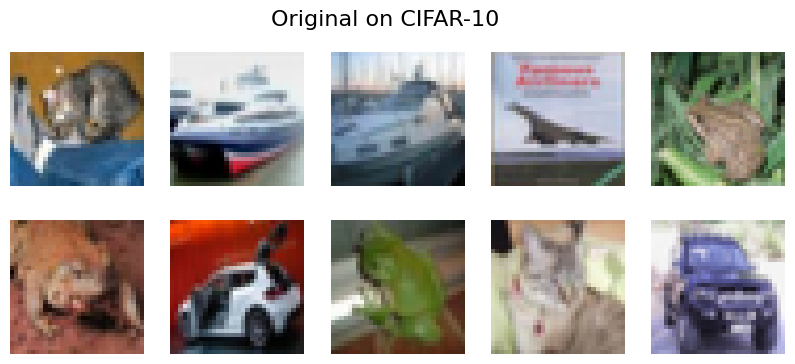

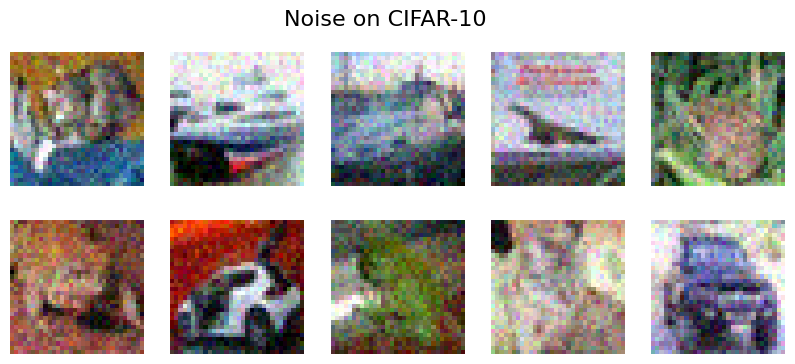

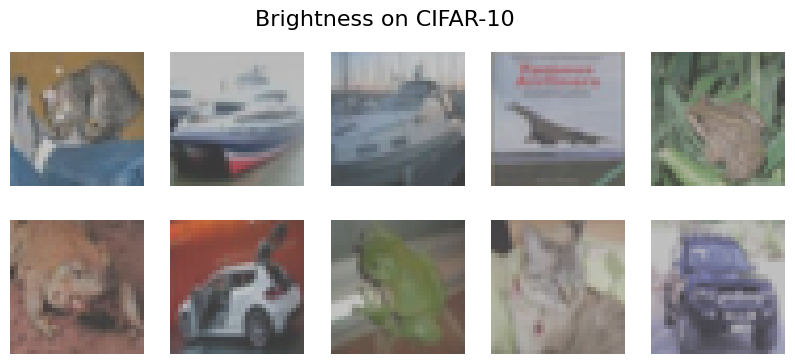

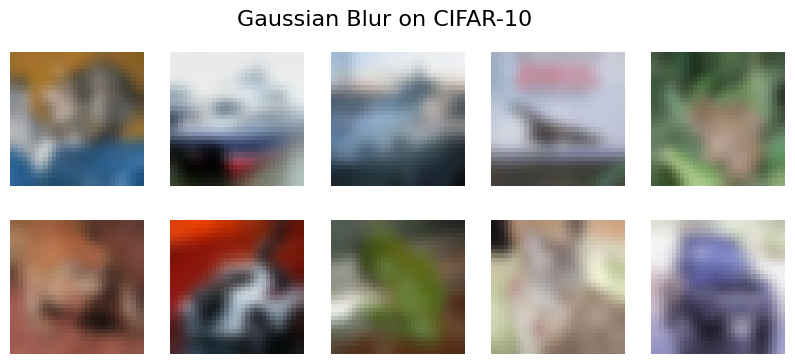

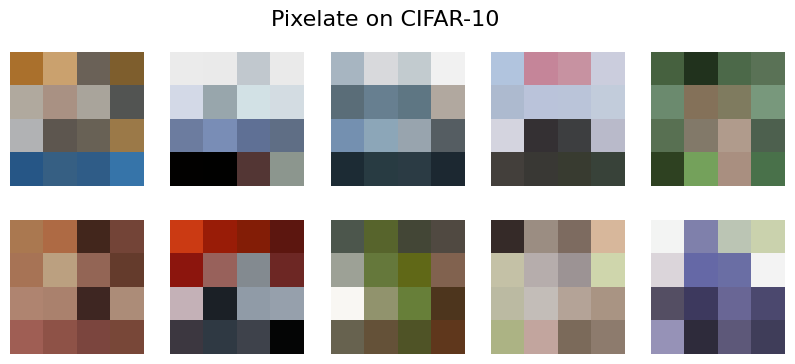

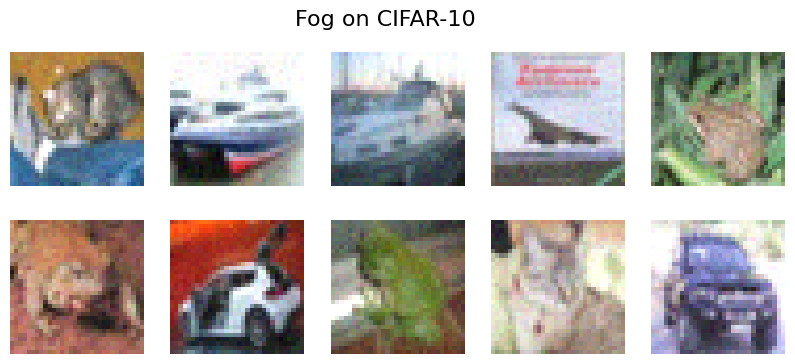

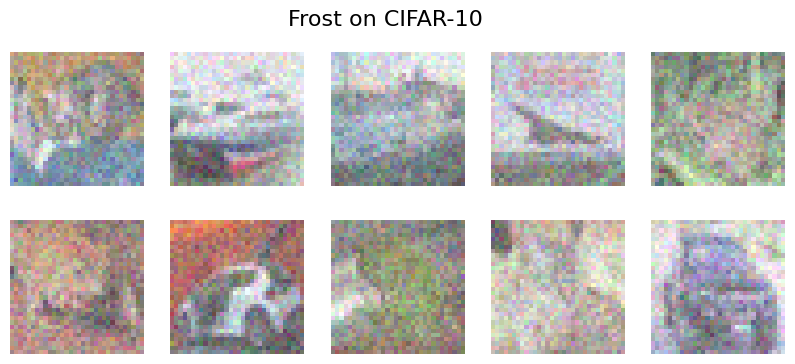

In [52]:
import matplotlib.pyplot as plt

SEVERITY = 3 #we have severity ranging 1-5, so choose the mid severity on these

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images[:10]  #show 10 images

attacks = {
    "Original": images,
    "Noise": add_noise(images, SEVERITY),
    "Brightness": change_brightness(images, SEVERITY),
    "Gaussian Blur": defocus_blur(images, SEVERITY),
    "Pixelate": pixelate(images, SEVERITY),
    "Fog": add_fog(images, SEVERITY),
    "Frost": frost(images, SEVERITY)
}

for name, attacked_imgs in attacks.items():
    plt.figure(figsize=(10, 4))
    for i in range(10):
        img = attacked_imgs[i] / 2 + 0.5  #unnormalise
        npimg = img.cpu().numpy()
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
    plt.suptitle(f'{name} on CIFAR-10', size=16)
    plt.show()


So now we've effectively created our modified test sets hat can be used to test the model's robustness on the CIFAR-10 dataset. The modifications and attack choices were chosen due to teh fact the mirror modifications that we might encounter in a real world scenario.

We create a function to evaluate how the models perform with these pertubations.

In [53]:
from torch.utils.data import TensorDataset, DataLoader
#we define a function that we can use to evaluate each of these 'scenarios' on our models
def evaluate_attack(model, attack_fn, testloader):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for severity in SEVERITY_LEVELS:
            correct = total = 0
            for images, labels in testloader:
                images = attack_fn(images, severity)
                outputs = model(images.to(device))
                _, preds = torch.max(outputs, 1)
                correct += (preds.cpu() == labels).sum().item()
                total += labels.size(0)
            accuracies.append(100 * correct / total)
    return accuracies

The model architecture can be found at Report-> Supplementary -> Models

And the trained model weights can be found :
Report-> Supplementary -> Trained models.

First we load the ResNet18, the Plain18 and the ViT models.
We use a link directly to GitHub to load our files.


In [54]:
import torch
import torch.nn as nn
import requests
file_path_resnet = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Model_architecture/Resnet18.py"

resnet_code = requests.get(file_path_resnet, headers={'User-Agent': 'Mozilla/5.0'}).text
exec(resnet_code)
print("ResNet18.py loaded from GitHub")

ResNet18_acc_URL  = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/Resnet18_from_scratch/resnet18_cifar10_best_acc.pth"
ResNet18_loss_URL = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/Resnet18_from_scratch/resnet18_cifar10_best_loss.pth"

ResNet18_acc_PATH  = "resnet18_cifar10_best_acc.pth"
ResNet18_loss_PATH = "resnet18_cifar10_best_loss.pth"

for url, filename in [(ResNet18_acc_URL, ResNet18_acc_PATH), (ResNet18_loss_URL, ResNet18_loss_PATH)]:
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    with open(filename, "wb") as f:
        f.write(r.content)

print("ResNet18 weights downloaded from GitHub")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_res_acc  = ResNet18(num_classes=10).to(device)
model_res_loss = ResNet18(num_classes=10).to(device)

state_res_acc  = torch.load(ResNet18_acc_PATH,  map_location=device, weights_only=False)
state_res_loss = torch.load(ResNet18_loss_PATH, map_location=device, weights_only=False)

missing_acc  = model_res_acc.load_state_dict(state_res_acc,  strict=False)
missing_loss = model_res_loss.load_state_dict(state_res_loss, strict=False)

model_res_acc.eval()
model_res_loss.eval()

print("ResNet18 models loaded successfully from GitHub!")




ResNet18.py loaded from GitHub
ResNet18 weights downloaded from GitHub
ResNet18 models loaded successfully from GitHub!


In [55]:
import torch
import torch.nn as nn
import requests
#we load our model from github
file_path_plain = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Model_architecture/Plain18.py"

plain_code = requests.get(file_path_plain).text
exec(plain_code)
print("Plain18.py loaded from GitHub")

plain18_acc_URL  = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/Plain18_from_scratch/plain18_cifar10_best_acc.pth"
plain18_loss_URL = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/Plain18_from_scratch/plain18_cifar10_best_loss.pth"

plain18_acc_PATH  = "plain18_cifar10_best_acc.pth"
plain18_loss_PATH = "plain18_cifar10_best_loss.pth"
for url, filename in [(plain18_acc_URL, plain18_acc_PATH), (plain18_loss_URL, plain18_loss_PATH)]:
    r = requests.get(url)
    with open(filename, "wb") as f:
        f.write(r.content)
print("Plain18 weights downloaded")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_plain_acc  = Plain18(num_classes=10).to(device)
model_plain_loss = Plain18(num_classes=10).to(device)

state_plain_acc  = torch.load(plain18_acc_PATH, map_location=device)
state_plain_loss = torch.load(plain18_loss_PATH, map_location=device)

model_plain_acc.load_state_dict(state_plain_acc)
model_plain_loss.load_state_dict(state_plain_loss)

model_plain_acc.eval()
model_plain_loss.eval()

print("Plain18 best-acc and best-loss models loaded successfully from GitHub!")


Plain18.py loaded from GitHub
Plain18 weights downloaded
Plain18 best-acc and best-loss models loaded successfully from GitHub!


In [56]:
import torch
import torch.nn as nn
import requests
file_path_vit = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Model_architecture/SL_Vit.py"
vit_code = requests.get(file_path_vit, headers={'User-Agent': 'Mozilla/5.0'}).text
exec(vit_code)
print("SL_ViT architecture loaded successfully from GitHub!")

Vit_acc_URL  = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/SLViT_from_scratch/slvit_cifar10_best_acc.pth"
Vit_loss_URL = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Trained_models/SLViT_from_scratch/slvit_cifar10_best_loss.pth"

Vit_acc_PATH  = "slvit_cifar10_best_acc.pth"
Vit_loss_PATH = "slvit_cifar10_best_loss.pth"

for url, filename in [(Vit_acc_URL, Vit_acc_PATH), (Vit_loss_URL, Vit_loss_PATH)]:
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    with open(filename, "wb") as f:
        f.write(r.content)

print("SL_ViT weights downloaded from GitHub")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vit_acc = ViT(
    image_size=32, patch_size=4, num_classes=10,
    dim=256, depth=6, heads=8, mlp_dim=512,
    dropout=0.1, emb_dropout=0.1
).to(device)

model_vit_loss = ViT(
    image_size=32, patch_size=4, num_classes=10,
    dim=256, depth=6, heads=8, mlp_dim=512,
    dropout=0.1, emb_dropout=0.1
).to(device)

state_vit_acc  = torch.load(Vit_acc_PATH,  map_location=device, weights_only=False)
state_vit_loss = torch.load(Vit_loss_PATH, map_location=device, weights_only=False)

missing_acc  = model_vit_acc.load_state_dict(state_vit_acc,  strict=False)
missing_loss = model_vit_loss.load_state_dict(state_vit_loss, strict=False)

model_vit_acc.eval()
model_vit_loss.eval()

print("SL_ViT best-ACC and best-LOSS models loaded successfully!")


SL_ViT architecture loaded successfully from GitHub!
SL_ViT weights downloaded from GitHub
SL_ViT best-ACC and best-LOSS models loaded successfully!


Now we evaluate for each model:

In [57]:
#evaluating for resnet18
attack_results_Res_acc = {
    "Noise":       evaluate_attack(model_res_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_res_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_res_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_res_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_res_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_res_acc, frost, testloader),
}

attack_results_Res_loss = {
    "Noise":       evaluate_attack(model_res_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_res_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_res_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_res_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_res_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_res_loss, frost, testloader),
}


In [60]:
#evaluating for transformer
attack_results_Vit_acc = {
    "Noise":       evaluate_attack(model_vit_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_vit_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_vit_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_vit_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_vit_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_vit_acc, frost, testloader),
}


attack_results_Vit_loss = {
    "Noise":       evaluate_attack(model_vit_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_vit_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_vit_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_vit_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_vit_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_vit_loss, frost, testloader),
}



In [59]:
#evaluating for plain18
attack_results_plain_acc = {
    "Noise":       evaluate_attack(model_plain_acc, add_noise, testloader),
    "Brightness":  evaluate_attack(model_plain_acc, change_brightness, testloader),
    "Blur":        evaluate_attack(model_plain_acc, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_plain_acc, pixelate, testloader),
    "Fog":         evaluate_attack(model_plain_acc, add_fog, testloader),
    "Frost":       evaluate_attack(model_plain_acc, frost, testloader),
}


attack_results_plain_loss = {
    "Noise":       evaluate_attack(model_plain_loss, add_noise, testloader),
    "Brightness":  evaluate_attack(model_plain_loss, change_brightness, testloader),
    "Blur":        evaluate_attack(model_plain_loss, defocus_blur, testloader),
    "Pixelate":    evaluate_attack(model_plain_loss, pixelate, testloader),
    "Fog":         evaluate_attack(model_plain_loss, add_fog, testloader),
    "Frost":       evaluate_attack(model_plain_loss, frost, testloader),
}

This results in the following plot, were we plot the accuracy of the models against the severity of the robustness test:

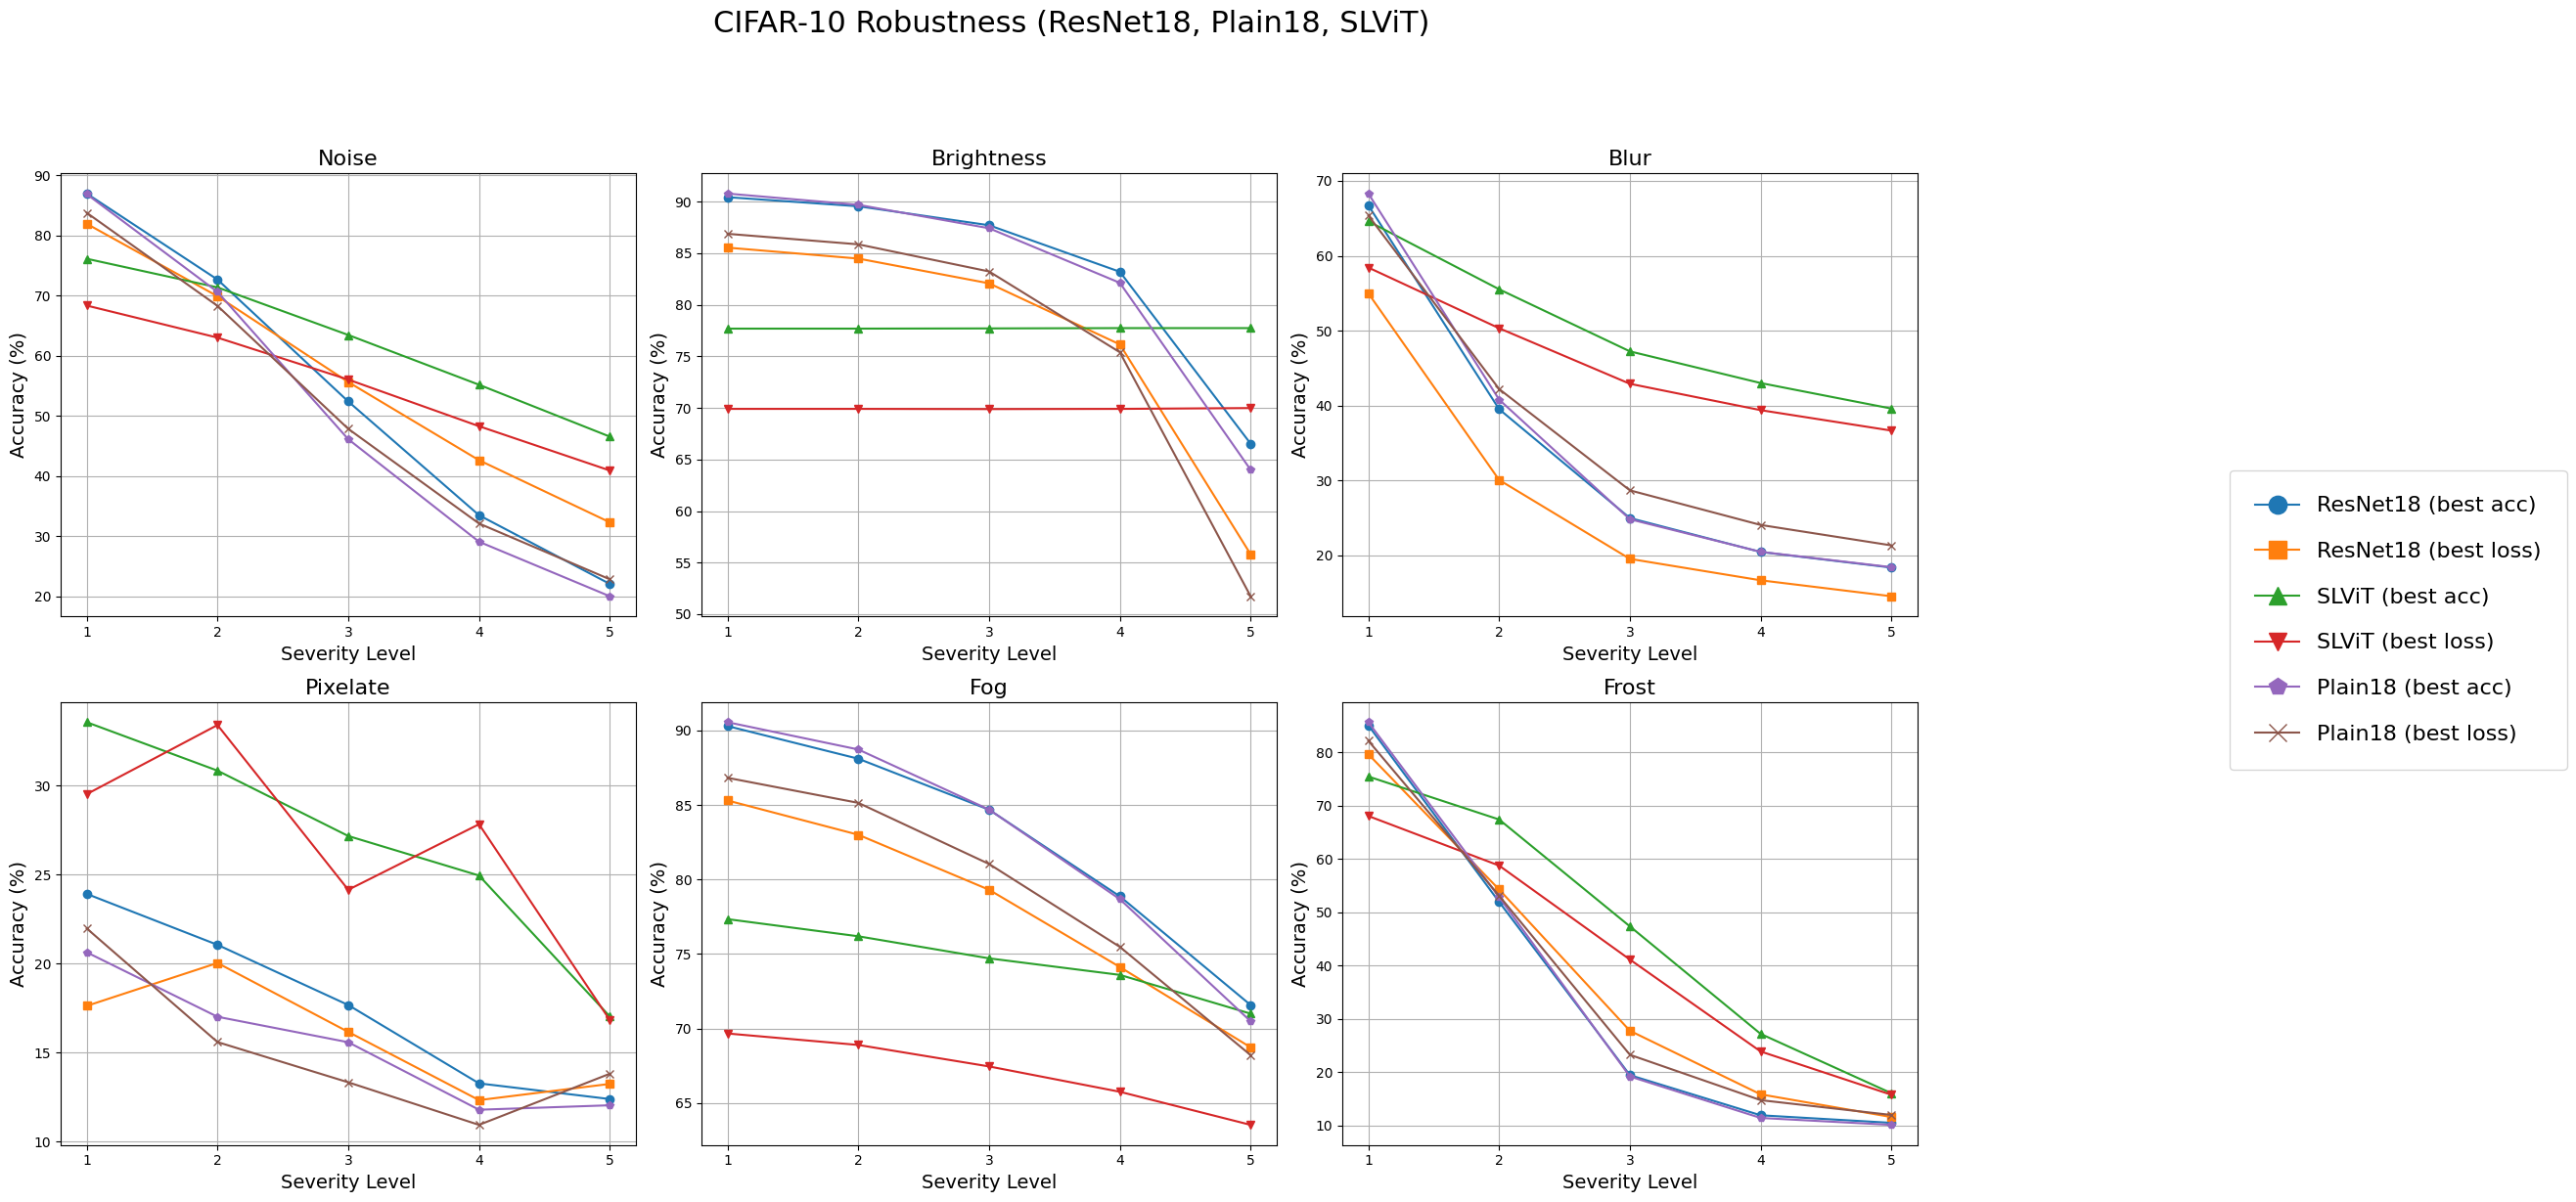

In [65]:
import matplotlib.pyplot as plt

attacks = list(attack_results_Res_acc.keys())
num_attacks = len(attacks)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(22, 12))
axes = axes.flatten()

for idx, attack_name in enumerate(attacks):
    ax = axes[idx]

    #curves for each
    acc_curve_res   = attack_results_Res_acc[attack_name]
    loss_curve_res  = attack_results_Res_loss[attack_name]
    acc_curve_vit   = attack_results_Vit_acc[attack_name]
    loss_curve_vit  = attack_results_Vit_loss[attack_name]
    acc_curve_plain = attack_results_plain_acc[attack_name]
    loss_curve_plain = attack_results_plain_loss[attack_name]

    #plotting
    ax.plot(SEVERITY_LEVELS, acc_curve_res,   marker='o', label='ResNet18 (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_res,  marker='s', label='ResNet18 (best loss)')
    ax.plot(SEVERITY_LEVELS, acc_curve_vit,   marker='^', label='SLViT (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_vit,  marker='v', label='SLViT (best loss)')
    ax.plot(SEVERITY_LEVELS, acc_curve_plain, marker='p', label='Plain18 (best acc)')
    ax.plot(SEVERITY_LEVELS, loss_curve_plain, marker='x', label='Plain18 (best loss)')

    ax.set_title(attack_name, fontsize=16)
    ax.set_xlabel("Severity Level", fontsize=14)
    ax.set_ylabel("Accuracy (%)", fontsize=14)
    ax.set_xticks(SEVERITY_LEVELS)
    ax.grid(True)

# Hide unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')
plt.suptitle("CIFAR-10 Robustness (ResNet18, Plain18, SLViT)", fontsize=22, y=1.02)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='center right',
    bbox_to_anchor=(1.0, 0.5),
    fontsize=16,
    markerscale=2.2,
    borderpad=1.2,
    labelspacing=1.2
)

plt.tight_layout(rect=[0, 0, 0.93, 0.95])

plt.show()



From the above plot we can clearly see ...

#Robustness on Food 101
Despite the fact these images are collected from a real world scenario, hence already including varied brightnesses and blur, we enhance these to test the robustness of our models.

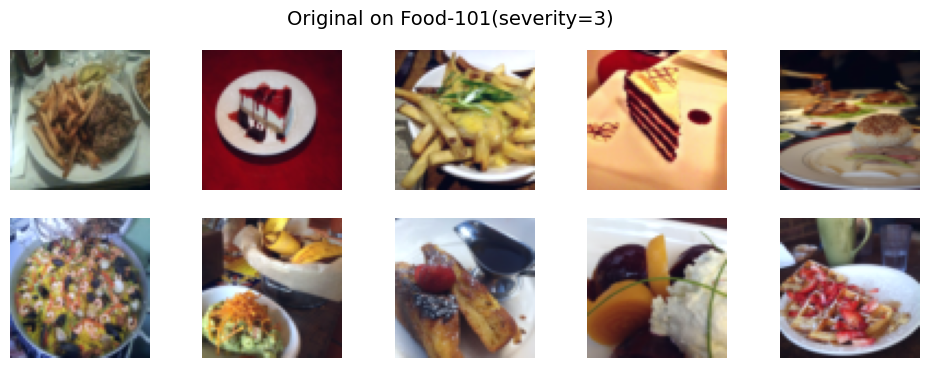

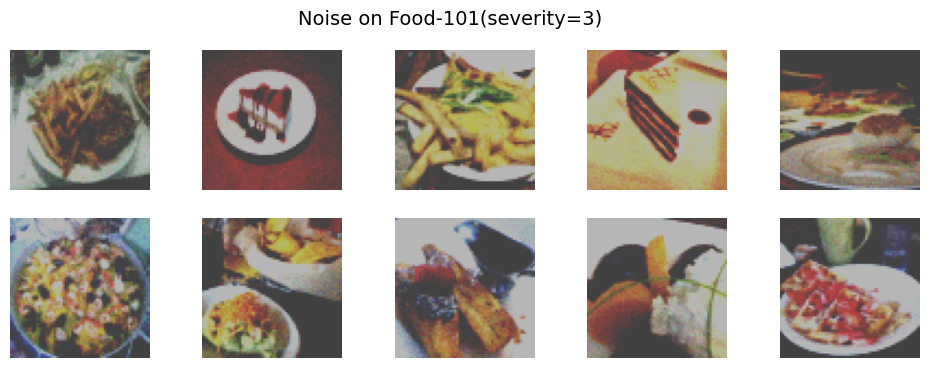

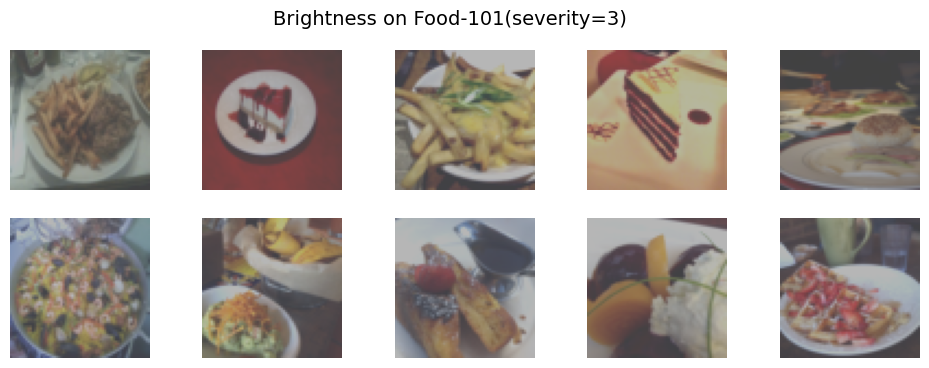

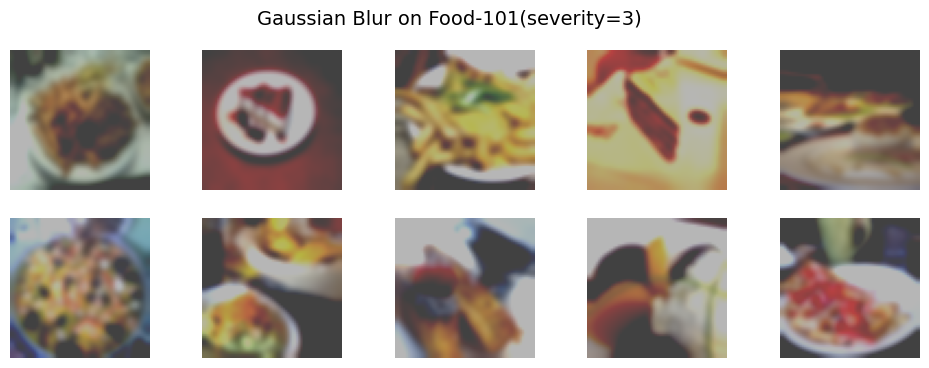

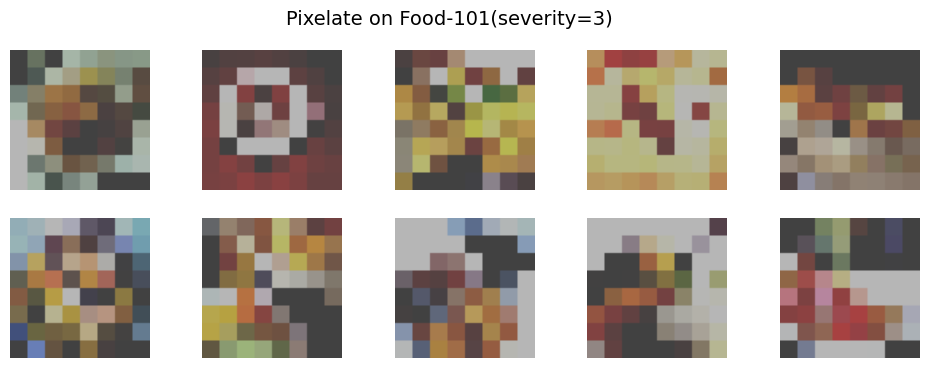

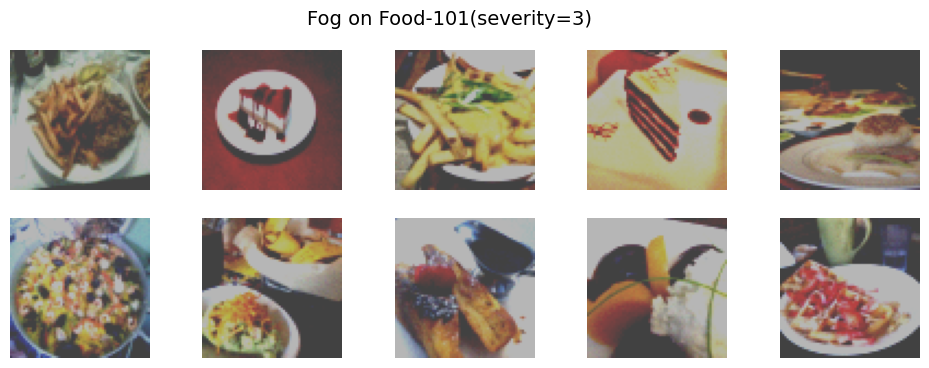

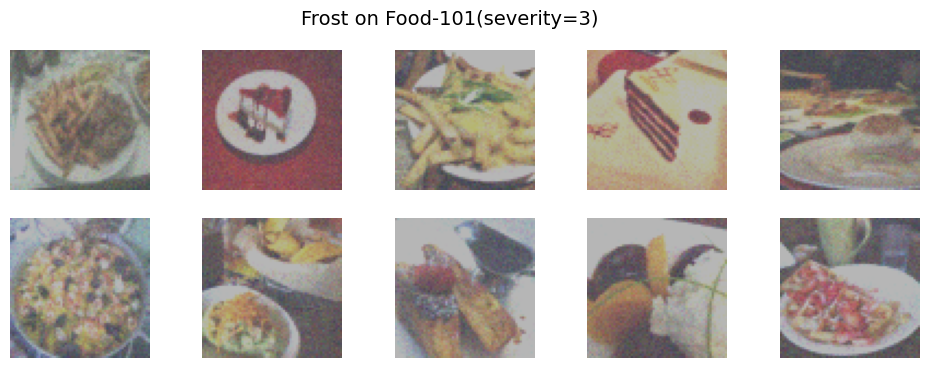

In [39]:
# Get one batch of tensors directly from DataLoader (images are already tensors)
images, labels = next(iter(train_loader64))

# Optional: use only first 10 images for plotting
images_64 = images[:10].clone()
labels_64 = labels[:10].clone()

# Apply corruptions
modifications = {
    "Original":      images_64,
    "Noise":         add_noise(images_64, severity=3),
    "Brightness":    change_brightness(images_64, severity=3),
    "Gaussian Blur": defocus_blur(images_64, severity=3),
    "Pixelate":      pixelate(images_64, severity=3),
    "Fog":           add_fog(images_64, severity=3),
    "Frost":         frost(images_64, severity=3)
}

# Visualise results
for name, attacked_imgs in modifications.items():
    plt.figure(figsize=(12, 4))
    for i in range(len(attacked_imgs)):
        img = attacked_imgs[i].cpu()  # bring back from GPU if needed
        img = img * 0.229 + 0.485  # undo normalization (approx.)
        npimg = img.numpy().transpose(1, 2, 0)

        plt.subplot(2, 5, i + 1)
        plt.imshow(npimg)
        plt.axis('off')

    plt.suptitle(f'{name} on Food-101(severity=3)', fontsize=14)
    plt.show()




Now we apply our neural networks to our adversarial attack datasets, the results can be seen in the visualisation below. But first we must load the models.





In [40]:
import torch
import torch.nn as nn
import requests
import os

file_path_resnet = "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/Report/Supplementary/Model_architecture/Resnet18.py"

resnet_code = requests.get(file_path_resnet, headers={'User-Agent': 'Mozilla/5.0'}).text
exec(resnet_code)
print("ResNet18 architecture loaded successfully!")

ResNet18_food_URL = (
    "https://raw.githubusercontent.com/K-Chorna02/DST_Assessment_2/main/"
    "Report/Supplementary/Trained_models/Resnet18_from_scratch/resnet18_food101_best.pth"
)

ResNet18_food_PATH = "resnet18_food101_best.pth"

r = requests.get(ResNet18_food_URL, headers={'User-Agent': 'Mozilla/5.0'})
with open(ResNet18_food_PATH, "wb") as f:
    f.write(r.content)

print(f"Food-101 weights downloaded (Size: {os.path.getsize(ResNet18_food_PATH)} bytes)")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_food_res = ResNet18(num_classes=101).to(device)

state_food_res = torch.load(
    ResNet18_food_PATH,
    map_location=device,
    weights_only=False
)

missing_keys = model_food_res.load_state_dict(state_food_res, strict=False)



ResNet18 architecture loaded successfully!
Food-101 weights downloaded (Size: 44963403 bytes)
Missing keys: []
Model loaded successfully!


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, mo

In [42]:
import torch
import torch.nn as nn
import requests
import os

file_path_vit = (
    "https://raw.githubusercontent.com/K-Chorna02/"
    "DST_Assessment_2/main/Report/Supplementary/Model_architecture/SL_Vit.py"
)

vit_code = requests.get(file_path_vit, headers={'User-Agent': 'Mozilla/5.0'}).text
exec(vit_code)
print("SLViT architecture loaded successfully from GitHub!")

Vit_food_URL = (
    "https://raw.githubusercontent.com/K-Chorna02/"
    "DST_Assessment_2/main/Report/Supplementary/Trained_models/SLViT_from_scratch/slvit_food101_best.pth"
)

Vit_food_PATH = "slvit_food101_best.pth"

r = requests.get(Vit_food_URL, headers={'User-Agent': 'Mozilla/5.0'})
with open(Vit_food_PATH, "wb") as f:
    f.write(r.content)

print(f"Food-101 ViT weights downloaded (Size: {os.path.getsize(Vit_food_PATH)} bytes)")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_food_vit():
    return ViT(
        image_size=64, patch_size=8, num_classes=101,
        dim=256, depth=6, heads=8, mlp_dim=512,
        dropout=0.1, emb_dropout=0.1
    )

model_vit_food = make_food_vit().to(device)

state_vit_food = torch.load(
    Vit_food_PATH,
    map_location=device,
    weights_only=False
)


model_vit_food.eval()

print("SLViT Food-101 model loaded successfully!")


SLViT architecture loaded successfully from GitHub!
Food-101 ViT weights downloaded (Size: 20122997 bytes)
Missing keys: []
SLViT Food-101 model loaded successfully!


In [ ]:
attack_results_Food101_ResNet_best = {
    "Noise":       evaluate_attack(model_food_res, add_noise, test_loader64),
    "Brightness":  evaluate_attack(model_food_res, change_brightness, test_loader64),
    "Blur":        evaluate_attack(model_food_res, defocus_blur, test_loader64),
    "Pixelate":    evaluate_attack(model_food_res, pixelate, test_loader64),
    "Fog":         evaluate_attack(model_food_res, add_fog, test_loader64),
    "Frost":       evaluate_attack(model_food_res, frost, test_loader64),
}


In [ ]:
attack_results_Food101_ViT_best = {
    "Noise":       evaluate_attack(model_vit_food, add_noise, test_loader64),
    "Brightness":  evaluate_attack(model_vit_food, change_brightness, test_loader64),
    "Blur":        evaluate_attack(model_vit_food, defocus_blur, test_loader64),
    "Pixelate":    evaluate_attack(model_vit_food, pixelate, test_loader64),
    "Fog":         evaluate_attack(model_vit_food, add_fog, test_loader64),
    "Frost":       evaluate_attack(model_vit_food, frost, test_loader64),
}

In [ ]:
plt.suptitle("Food-101 Robustness (ResNet18 vs SLViT)", fontsize=16, y=1.02)

attacks = list(attack_results_Food101_ResNet_best.keys())
num_attacks = len(attacks)

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
axes = axes.flatten()

for idx, attack_name in enumerate(attacks):
    ax = axes[idx]
    acc_curve_resnet = attack_results_Food101_ResNet_best[attack_name]#curves for each
    acc_curve_vit    = attack_results_Food101_ViT_best[attack_name]
    ax.plot(SEVERITY_LEVELS, acc_curve_resnet, marker='o', label='ResNet18')#plotting
    ax.plot(SEVERITY_LEVELS, acc_curve_vit,    marker='s', label='SLViT')

    ax.set_title(attack_name)
    ax.set_xlabel("Severity Level")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xticks(SEVERITY_LEVELS)
    ax.grid(True)
    ax.legend(fontsize=8)

# Hide any unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



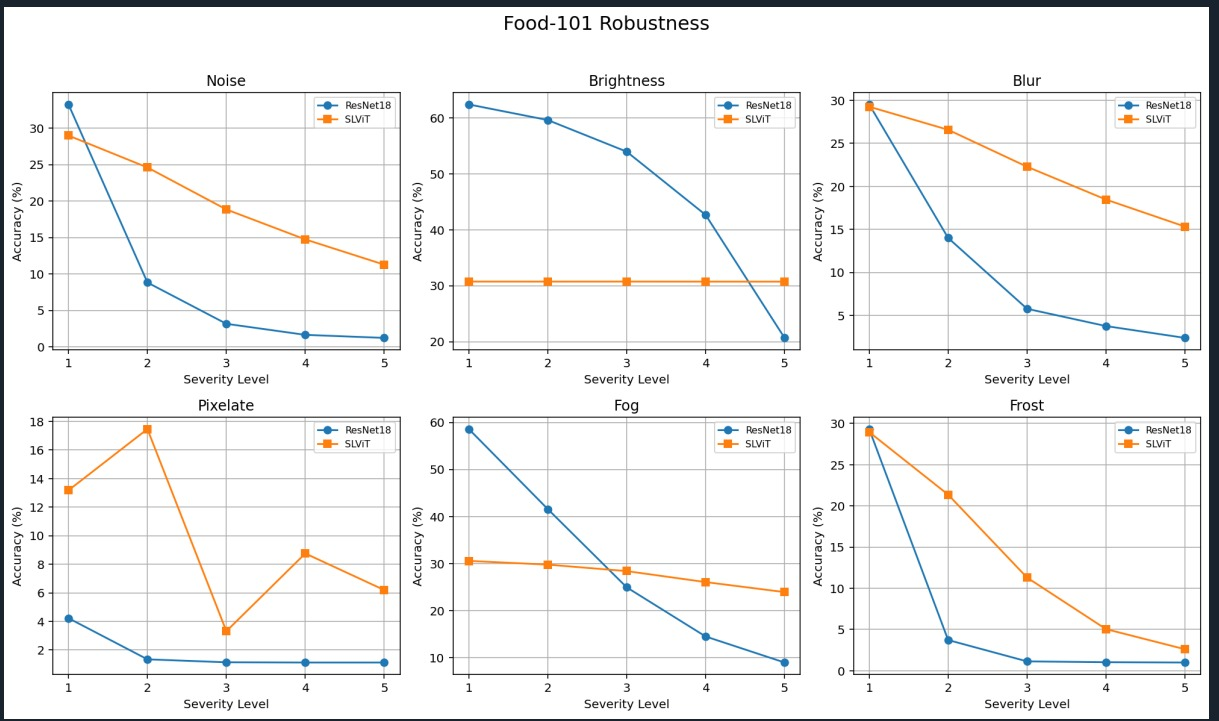

Since this code takes a while to run we have included a visualisation as shown above.

This clearly shows that performance is worse for the pixelation, which is to be expected as this is the hardest transformation to interpret. Interestingly, SLViT is not affected by the brightness transformation, while ResNet18's performance decreases in accuracy as the severity increases.

Overall we see that




# t-SNE on CIFAR-10 Gaussian noise
To clearly visualise how the model separates classes and the effect of noise on the model's performance, we use t-distributed Stochastic Neighbor Embedding (t-SNE). Unlike linear methods such as PCA that we used in the EDA, this approach allows us to capture non-linear relationships by keeping the local structure of data points.
We apply t-SNE to feature vectors that we extracted from the penultimate layer.

We produce 3 plots, one for ResNet18 applied directly to clean CIFAR-10, one where we have applied Gaussian noise applied tseverity 1 and another at severity 5.


#### t-SNE on ResNet18 for CIFAR-10

Extracting (noise=5): 100%|██████████| 100/100 [00:00<00:00, 212.01it/s]


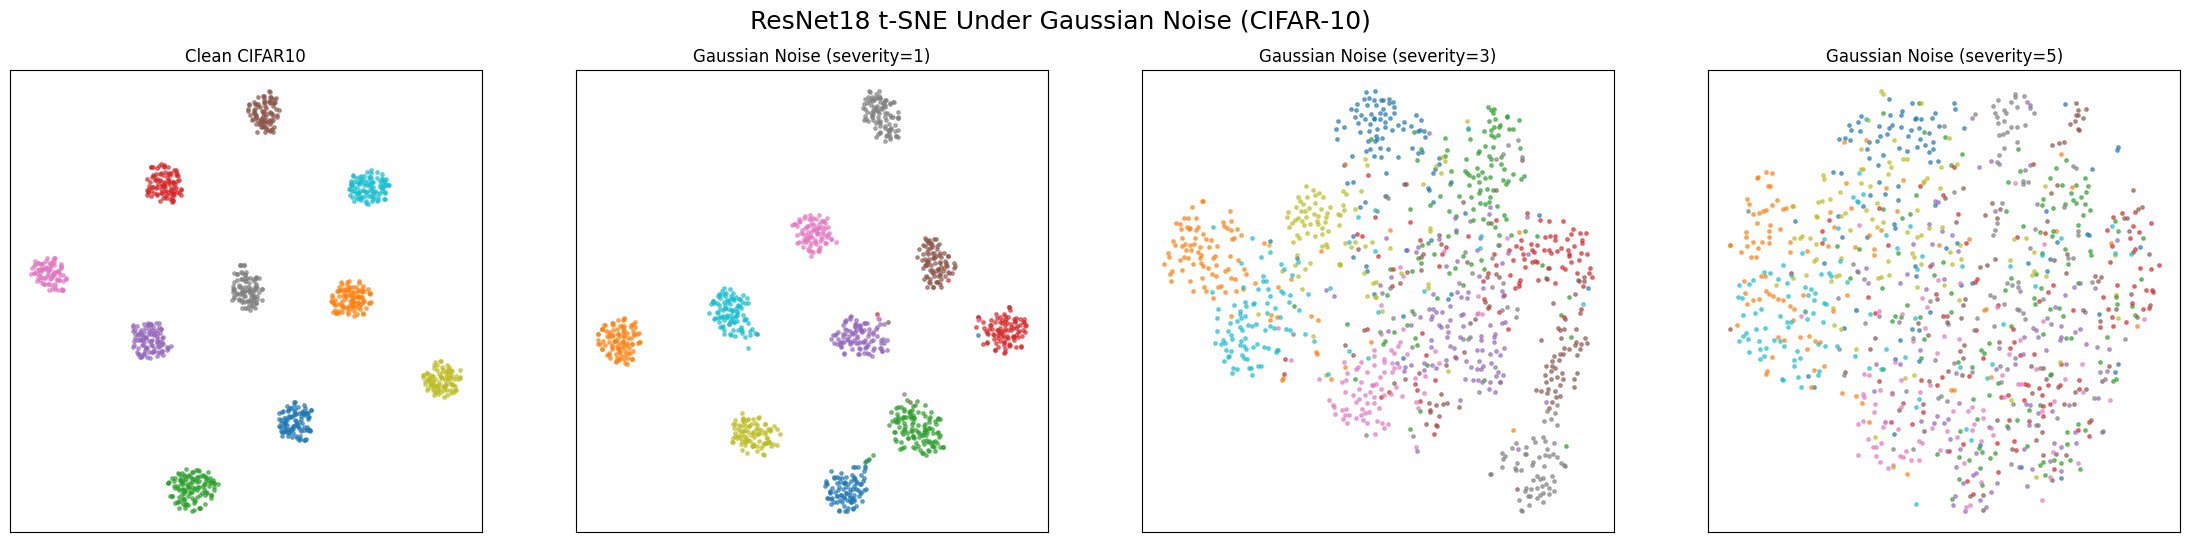

In [49]:
def get_small_loader(dataloader, num_batches=100):
    small_data = []
    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break
        small_data.append(batch)
    return small_data

small_train = get_small_loader(trainloader)

#extractor
feature_extractor_res = torch.nn.Sequential(*list(model_res_acc.children())[:-1])

def extract_features(dataloader, noise_severity=None):
    model_res_acc.eval()
    features, labels = [], []

    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc=f"Extracting (noise={noise_severity})"):
            images = images.to(device)
            if noise_severity is not None:
                images = add_noise(images, severity=noise_severity)

            feats = feature_extractor_res(images).squeeze()
            features.append(feats.cpu().numpy())
            labels.extend(lbls.numpy())

    return np.vstack(features), np.array(labels)

#extracting for severities 0,1,3,5
clean_feats, clean_lbls = extract_features(small_train, noise_severity=None)
s1_feats, s1_lbls = extract_features(small_train, noise_severity=1)
s3_feats, s3_lbls = extract_features(small_train, noise_severity=3)
s5_feats, s5_lbls = extract_features(small_train, noise_severity=5)

def tsne_single(features):
    pca = PCA(n_components=50)
    reduced = pca.fit_transform(features)
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    return tsne.fit_transform(reduced)

clean_tsne = tsne_single(clean_feats)
s1_tsne    = tsne_single(s1_feats)
s3_tsne    = tsne_single(s3_feats)
s5_tsne    = tsne_single(s5_feats)

fig, axes = plt.subplots(1, 4, figsize=(28, 6))

def plot_single(ax, X, labels, title):
    classes = trainset.classes
    for i, cls in enumerate(classes):
        idx = labels == i
        ax.scatter(X[idx, 0], X[idx, 1], s=6, alpha=0.6)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

plot_single(axes[0], clean_tsne, clean_lbls, "Clean CIFAR10")
plot_single(axes[1], s1_tsne,   s1_lbls,   "Gaussian Noise (severity=1)")
plot_single(axes[2], s3_tsne,   s3_lbls,   "Gaussian Noise (severity=3)")
plot_single(axes[3], s5_tsne,   s5_lbls,   "Gaussian Noise (severity=5)")

plt.suptitle("ResNet18 t-SNE Under Gaussian Noise (CIFAR-10)", fontsize=18)
plt.show()


As we can see, t-SNE provides a clear visual as to the affect Gaussian noise has on the robustness of ResNet18 on CIFAR-10.
We plotted with severity=1,3,5 along with the clean dataset.
This shows ...


#### t-SNE on ViT for CIFAR-10

Extracting features (noise=5): 100%|██████████| 100/100 [00:00<00:00, 179.34it/s]


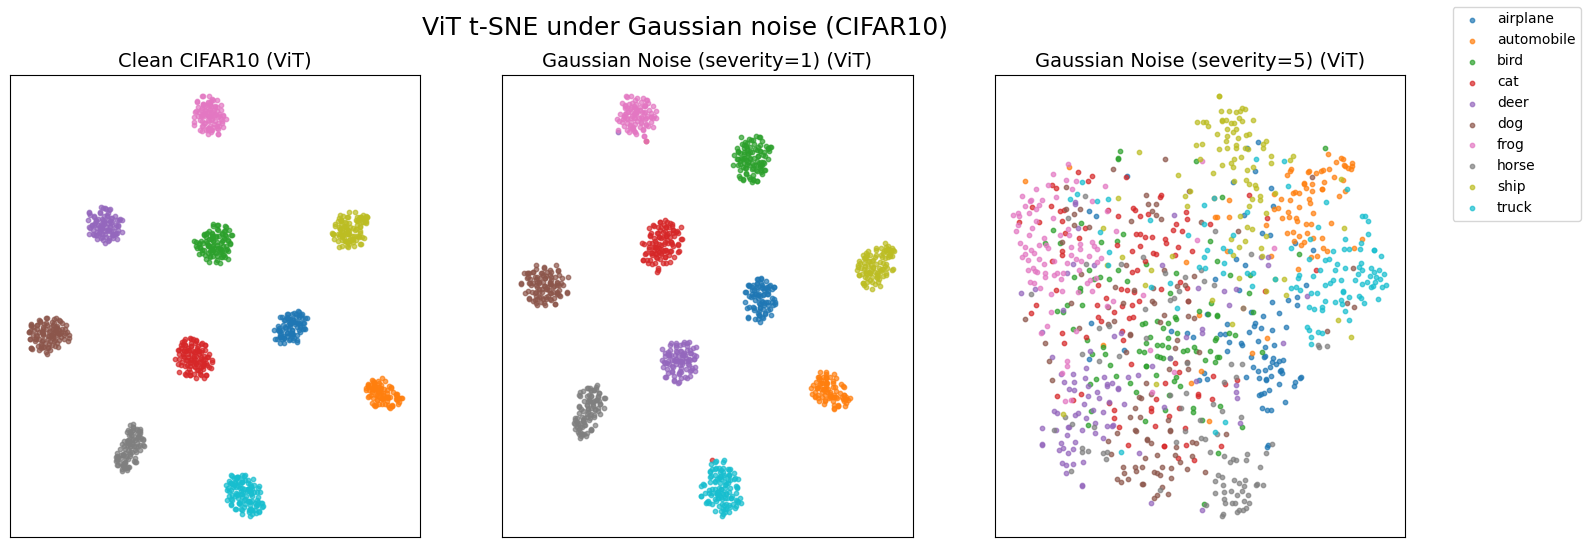

In [58]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def get_small_loader(dataloader, num_batches=100):
    small_data = []
    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break
        small_data.append(batch)
    return small_data

small_train = get_small_loader(trainloader, num_batches=100)

def vit_forward_features(model, images):
    x = model.to_patch_embedding(images)
    b, n, _ = x.shape
    cls_tokens = model.cls_token.expand(b, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)
    x = x + model.pos_embedding[:, :(n + 1)]
    x = model.dropout(x)
    x = model.transformer(x)
    if model.pool == 'mean':
        x = x.mean(dim=1)
    else:
        x = x[:, 0]

    return model.to_latent(x)

def extract_vit_features(dataloader, noise_severity=None, max_points=5000):
    model_vit_acc.eval()
    features, labels = [], []
    total = 0

    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc=f"Extracting features (noise={noise_severity})"):
            images = images.to(device)
            if noise_severity is not None:
                images = add_noise(images, severity=noise_severity)

            feats = vit_forward_features(model_vit_acc, images)  # (B, dim)

            features.append(feats.cpu())
            labels.append(lbls)

            total += lbls.size(0)
            if total >= max_points:
                break

    features = torch.cat(features)[:max_points].numpy()
    labels   = torch.cat(labels)[:max_points].numpy()
    return features, labels

#we vary severity as 0, 1,5
clean_feats_vit,  clean_lbls_vit  = extract_vit_features(small_train, noise_severity=None)
noisy1_feats_vit, noisy1_lbls_vit = extract_vit_features(small_train, noise_severity=1)
noisy5_feats_vit, noisy5_lbls_vit = extract_vit_features(small_train, noise_severity=5)

def tsne_single(features):
    pca = PCA(n_components=50)
    reduced = pca.fit_transform(features)
    tsne = TSNE(n_components=2, random_state=42, init='pca')
    return tsne.fit_transform(reduced)

clean_tsne_vit  = tsne_single(clean_feats_vit)
noisy1_tsne_vit = tsne_single(noisy1_feats_vit)
noisy5_tsne_vit = tsne_single(noisy5_feats_vit)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

def plot_single(ax, X, labels, title):
    classes = trainset.classes
    for i, cls in enumerate(classes):
        idx = labels == i
        ax.scatter(X[idx, 0], X[idx, 1], s=10, alpha=0.7, label=cls)
    ax.set_title(title, fontsize=14)
    ax.set_xticks([]); ax.set_yticks([])

plot_single(axes[0], clean_tsne_vit,  clean_lbls_vit,  "Clean CIFAR10 (ViT)")
plot_single(axes[1], noisy1_tsne_vit, noisy1_lbls_vit, "Gaussian Noise (severity=1) (ViT)")
plot_single(axes[2], noisy5_tsne_vit, noisy5_lbls_vit, "Gaussian Noise (severity=5) (ViT)")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.suptitle("ViT t-SNE under Gaussian noise (CIFAR10)", fontsize=18)
plt.show()



# Parallelism and Scalability

## Parallelism
Parallelism is the concept of performing many computations at the same time, rather than one after another. A CPU usually has a small number of powerful cores, which are great at handling tasks sequentially, one step at a time. A GPU has thousands of smaller cores that are designed to do many calculations simultaneously. Each core can handle part of a large computation. So when tasks can be parallelised, such as processing many pixels or features in an image, the GPU can complete them much faster than a CPU. We used CUDA through PyTorch, which automatically manages computations on the GPU by splitting them into many small tasks called threads, allowing operations such as convolutions, pooling, and matrix multiplications to be executed simultaneously.

This parallelism is particularly important for CNNs, which perform a large number of operations across multiple layers and channels. Each convolution involves many operations that can be done at the same time. On a CPU, these would be executed sequentially, making the process very slow for deep networks or large images. GPUs allow these operations to happen in parallel, computing outputs for multiple pixels, channels, and filters at once. This drastically reduces training time, enables more experiments to run, and makes it possible to scale to deeper networks and larger datasets.

##Scalability


# References

**[1]** Bossard, L., Guillaumin, M., & Van Gool, L. (2014). *Food-101 – Mining Discriminative Components with Random Forests*.  
European Conference on Computer Vision.  
Available at: https://link.springer.com/chapter/10.1007/978-3-319-10599-4_29  

**[2]** Kumar, V., Shukla, S., & Agarwal, A. (2025). *Robustness Benchmarking of Convolutional and Transformer Architectures for Image Classification*.  
IEEE Transactions on Big Data, 11(6), 3330–3341.  
DOI: 10.1109/TBDATA.2025.3593385  
Available at: https://ieeexplore.ieee.org/abstract/document/11098661  

**[3]** He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Deep Residual Learning for Image Recognition*.  
arXiv preprint arXiv:1512.03385.  
Available at: https://arxiv.org/pdf/1512.03385  

**[4]** Baez, J. C. (2025). *What is Entropy?*  
arXiv preprint arXiv:2409.09232.  
Available at: https://arxiv.org/abs/2409.09232  


**[5]** Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017).  
*Attention Is All You Need*.  
arXiv preprint arXiv:1706.03762.  
Available at: http://arxiv.org/abs/1706.03762  


